# Analyse dynamique des déterminants des prix immobiliers et de l'impact des taux d'intérêt sur le marché du logement

**Projet Python - 2A ENSAE**

## Introduction

Ce projet python vise à étudier l'influence des taux d'intérêt sur les prix immobilier au niveau local en fonction de divers caractéristiques. L'objectif principal est de déterminer si l'impact des taux d'intérêt peut être observé e façon homogène sur le territoire français. La question de l'effet des taux sur le marché immobilier est traité de façon assez large dans la littérature, souvent à des niveaux assez agrégés comme un pays (voir un working paper de la BCE House prices and ultra-low interest rates: exploring the non-linear nexus, Dieckelmann et al). Ce projet a donc la particularité de travailler à un niveau bien plus micro, l'échelon local.

Notre analyse est limitée à la période de disponibilité des données "Demandes de Valeurs Foncières" (2014-2023) qui listent toutes les transactions immobilièeres réalisées sur le territoire français, et nous permettent de construire des bases locales des marchés immobiliers.

Ce notebook peut se décomposer en 3 grandes parties :

Partie I - Préparation des données de la DVF
1. Récupération des données

2. Agrégation en utilisant des tables de passage

---

3. Visualisation et étude des données de la DVF

---

Partie II - Préparation des variables de contrôle

1. Récupération des données

2. Création d'une table variable de contrôle

3. Visualisation des données de contrôle

---

Partie III - Analyse, modélisation et économétrie

1. Test de Granger

2. Corrélations

3. Modèles communaux

4. Modèle avec prix dé-tendanciés

5. Modèle ZE

6. Modèle EPCI

Pour faciliter le contrôle de version, notre travail a été initialement réalisé sur 4 scripts indépendants, ce qui représente un avantage inattendu puisque le code présent dans ce notebook peut être utilisé de façon indépendante entre les 4 sections indiquées plus haut par des lignes horizontales.

## Les importations 

In [1]:
import pandas as pd
import numpy as np
import pyarrow.feather as feather
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import grangercausalitytests
from linearmodels import PanelOLS, RandomEffects
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.panel import compare
from statsmodels.tsa.stattools import adfuller

In [2]:
# Change path as needed
path = "C:/Users/lujul/interestnpy"

## Partie I. Préparation des données de la DVF

## 1. Récupération des données

### Création de la table de passage 

La géographie des communes en France a changé entre 2014 et 2023. Nous avons donc dû construire une table de passage pour prendre en compte ce problème.

In [3]:
#IMPORTS AND FILTER INSEE TRANSLATION TABLE
passage1423_df = pd.read_excel(path+"/data/external/GEOCOM/table_passage_annuelle_2023.xlsx", 
                               sheet_name="COM", skiprows=5)
passage1423_df = passage1423_df.filter(regex='^CODGEO').iloc[:, :10]
passage1423_df = passage1423_df[passage1423_df['CODGEO_2023'].notna()]

In [4]:
#IMPORTS 2023 EPCI DEFINITIONS
fcom_df = pd.read_excel(path+"/data/external/GEOCOM/ZE2020_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

epc_com = pd.read_excel(path+"/data/external/GEOCOM/Intercommunalite_Metropole_au_01-01-2023.xlsx", 
                            sheet_name="Composition_communale", skiprows=5)

fcom_df = pd.merge(fcom_df, epc_com, how='left', on=['CODGEO','LIBGEO', 'DEP', 'REG'])

In [5]:
#CREATES COM BASED ON 2023 TOWN CODES AND ZE BASED ON EPCI
fcom_df['COM'] = fcom_df['CODGEO']
fcom_df['LIB_COM'] = fcom_df['LIBGEO']
fcom_df['ZE'] = fcom_df['ZE2020']
fcom_df['LIB_ZE'] = fcom_df['LIBZE2020']
fcom_df['EPCI'] = fcom_df['ZE2020']
fcom_df['LIB_ZE'] = fcom_df['LIBZE2020']
fcom_df['EPCI'] = fcom_df.apply(
    lambda row: row['CODGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['EPCI'],
    axis=1
)
fcom_df['LIB_EPCI'] = fcom_df.apply(
    lambda row: row['LIBGEO'] if any(x in row['LIBEPCI'] for x in ["Métropole du Grand Paris", "Métropole de Lyon", "Métropole d'Aix-Marseille-Provence"]) else row['LIBEPCI'],
    axis=1
)
fcom_df['LIB_EPCI'] = fcom_df.apply(
    lambda row: "Iles-FR" if row['EPCI'] == "ZZZZZZZZZ" else row['LIB_EPCI'],
    axis=1
)
fcom_df.rename(columns={'CODGEO': 'CODGEO_2023'}, inplace=True)
fcom_df = fcom_df[['CODGEO_2023', 'COM', 'LIB_COM', 'ZE', 'LIB_ZE', 'EPCI', 'LIB_EPCI']]

In [6]:
#MERGES WITH INSEE TABLE TO CREATE THE TRANSLATION TABLE 
ident1423_df = pd.merge(passage1423_df, fcom_df, how='left', on='CODGEO_2023')

In [7]:
#FIXES PROBLEMS RELATED TO CITIES WITH "ARRONDISSEMENTS"
conditions_arr = [
    ident1423_df['CODGEO_2023'].str.startswith("75"),
    ident1423_df['CODGEO_2023'].str.startswith("132"),
    ident1423_df['CODGEO_2023'].str.startswith("6938")
]

ze_arr = [1109, 9312, 8421]
lib_arr = ["Paris", "Marseille", "Lyon"]

ident1423_df['COM'] = ident1423_df.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['COM']) else row['COM'],
    axis=1
)

ident1423_df['EPCI'] = ident1423_df.apply(
    lambda row: row['CODGEO_2023'] if pd.isna(row['EPCI']) else row['EPCI'],
    axis=1
)
ident1423_df['EPCI'] = ident1423_df['EPCI'].astype(str)

ident1423_df['ZE'] = np.select(
  conditions_arr, 
  ze_arr, 
  default=ident1423_df['ZE'])

In [8]:
def create_lib_ident(row, col_name):
    if pd.isna(row[col_name]):
        if row['COM'][:2] == "75":
            return f"Paris {row['COM'][3:5]}"
        elif row['COM'][:2] == "69":
            return f"Lyon {int(row['CODGEO_2019']) - 80}"
        elif row['COM'][:2] == "13":
            return f"Marseille {row['COM'][3:5]}"
    else:
        return row[col_name]

In [9]:
ident1423_df['LIB_COM'] = ident1423_df.apply(create_lib_ident, col_name='LIB_COM', axis=1)

ident1423_df['LIB_EPCI'] = ident1423_df.apply(
    lambda row: row['LIB_COM'] if pd.isna(row['LIB_EPCI']) else row['LIB_EPCI'],
    axis=1
) 

ident1423_df['LIB_ZE'] = np.select(
  conditions_arr, 
  lib_arr, 
  default=ident1423_df['LIB_ZE'])

In [10]:
#REORDERS AND EXPORTS THE TRANSLATION TABLE
reord_cols = ['COM', 'ZE', 'LIB_COM', 'LIB_ZE', 'EPCI', 'LIB_EPCI']
ident1423_df = ident1423_df[reord_cols + [col for col in ident1423_df.columns if col not in reord_cols]]
ident1423_df.to_feather(path+"/data/interim/tble_de_passage_py.feather")

In [11]:
ident1423_df.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO_2023,CODGEO_2022,CODGEO_2021,CODGEO_2020,CODGEO_2019,CODGEO_2018,CODGEO_2017,CODGEO_2016,CODGEO_2015,CODGEO_2014
0,13201,9312.0,Marseille 01,Marseille,13201,Marseille 01,13201,13201,13201,13201,13201,13201,13201,13201,13201,13201
1,13202,9312.0,Marseille 02,Marseille,13202,Marseille 02,13202,13202,13202,13202,13202,13202,13202,13202,13202,13202
2,13203,9312.0,Marseille 03,Marseille,13203,Marseille 03,13203,13203,13203,13203,13203,13203,13203,13203,13203,13203
3,13204,9312.0,Marseille 04,Marseille,13204,Marseille 04,13204,13204,13204,13204,13204,13204,13204,13204,13204,13204
4,13205,9312.0,Marseille 05,Marseille,13205,Marseille 05,13205,13205,13205,13205,13205,13205,13205,13205,13205,13205


### Prix des terrains par département

Nous utilisons des données du Ministère de la Transition écologique sur les prix des terrains par région de 2008 à 2022 afin de soustraire les prix des terrains des montants des transactions dans les données DVF.

In [12]:
#LOADS CONVERSION TABLE REG - DEP
depreg_df = pd.read_excel(path+"/data/external/GEOCOM/table-appartenance-geo-communes-19.xls", 
                          sheet_name="COM", skiprows=5)[['DEP', 'REG']].drop_duplicates()
depreg_df['REG'] = depreg_df['REG'].astype(str)

#LOADS REGIONAL PRICES FOR LAND
ter_df = pd.read_csv(path+"/data/external/TER/1-Terrains-achetes-nombre-surface-et-prix-moyen-par-region.2022-01.csv", 
                     delimiter=";", skiprows=1, escapechar='\\', skipinitialspace=True)

In [13]:
#CREATING ADDITIONAL CONSTANT VALUES FOR 2023
additional_rows_2023 = ter_df[ter_df['ANNEE'] == 2022].copy()
additional_rows_2023['ANNEE'] = 2023
ter_df = pd.concat([ter_df, additional_rows_2023]).sort_values('ANNEE')
ter_df = ter_df[ter_df['ANNEE'] > 2013]

In [14]:
#MERGES TO GO FROM REGIONAL LEVEL TO DEPARTMENT LEVEL AND EXPORTS
terdep_df = pd.merge(depreg_df, ter_df, left_on='REG', right_on='ZONE_CODE', how='left')
terdep_df = terdep_df.dropna().reset_index(drop=True)[['ANNEE', 'DEP', 'PTM2_MED']]
terdep_df.to_feather(path+"/data/interim/terrains_py.feather")

In [15]:
terdep_df.head()

,ANNEE,DEP,PTM2_MED
0,2014.0,01,105.0
1,2015.0,01,100.0
2,2016.0,01,100.0
3,2017.0,01,103.0
4,2018.0,01,106.0


### Inflation - Taux d'intérêt

In [16]:
#INFLATION TABLE
inflation = pd.read_excel(path+"/data/external/INFLATION/econ-gen-taux-inflation.xlsx", 
                          sheet_name="Données", skiprows=3, nrows=9)
inflation.rename(columns={"Année": "AN", "Taux d'inflation": "INFLATION"}, inplace=True)
inflation['AN'] = inflation['AN'].astype(str)
inflation = inflation._append({'AN': str(2023), 'INFLATION': 2.3}, ignore_index=True)
#Why 2.3? first 3 months inflation
#either way it does not matter as we will work in basis 2023
inflation.sort_values(by="AN", inplace=True)
inflation['Date'] = inflation['AN']+"0101"
inflation.loc[len(inflation)] = ["2023",0, "20230401"]
inflation['TOT'] = (1 + inflation['INFLATION'].shift(1) / 100).cumprod()
inflation['TOT'] = inflation['TOT'].fillna(1)

In [17]:
# INTEREST RATES TABLE
interest_rates = pd.read_excel(path+"/data/external/INFLATION/series_panorama_202309.xlsx", 
                               sheet_name="G3", 
                               skiprows=6, 
                               names=["Date", "ir", "ir10_avg", "ir20_avg"])

interest_rates = interest_rates[interest_rates['Date'] > '2013-12-31']

interest_rates['quarter'] = interest_rates['Date'].dt.to_period('Q').astype(str)
interest_rates = interest_rates.groupby('quarter').agg({'ir': 'mean'}).reset_index()

In [18]:
def get_month_from_quarter(quarter):
    quarter_num = quarter.split("Q")[1]
    return {'1': '01', '2': '04', '3': '07', '4': '10'}.get(quarter_num, None)

In [19]:
interest_rates['themonth'] = interest_rates['quarter'].apply(get_month_from_quarter)
interest_rates['Date'] = (interest_rates['quarter'].str[:4] + interest_rates['themonth'] + "01")
interest_rates = interest_rates[['Date', 'ir']]

In [20]:
# Combine inflation and interest rates
irflation = pd.merge(interest_rates, inflation, on='Date', how='left')
irflation = irflation.interpolate(method="slinear", fill_value="extrapolate", limit_direction="both")
irflation['BASE14'] = irflation['TOT'] / irflation['TOT'].iloc[0]
irflation['BASE23'] = irflation['BASE14'] / irflation['BASE14'].iloc[37]
irflation.to_feather(path+"/data/interim/irflation.feather")

In [21]:
irflation.head()

,Date,ir,AN,INFLATION,TOT,BASE14,BASE23
0,20140101,3.183333,2014,0.500,1.00000,1.00000,0.869350
1,20140401,3.083333,NaN,0.375,1.00125,1.00125,0.870437
2,20140701,2.883333,NaN,0.250,1.00250,1.00250,0.871524
3,20141001,2.683333,NaN,0.125,1.00375,1.00375,0.872610
4,20150101,2.506667,2015,0.000,1.00500,1.00500,0.873697


## 2. Agrégation en utilisant des tables de passage

Dans cette partie, on agrège les données DVF trimestriellement en utilisant une fonction personnalisée à 3 niveaux distincts : commune, EPCI et zone d'emploi. Les données ont été filtrées et à chaque niveau d'agrégation, 3 variables d'intérêt ont été gardées : le nombre de transactions, le prix médian et la part des maisons dans le total des transactions. Cette proportion est utilisée comme variable de contrôle pour les différences structurelles du marché de l'immobilier des différentes communes car les maisons sont souvent moins chères au mètre carré que les appartements.

In [87]:
terdep_df = pd.read_feather(path+"/data/interim/terrains_py.feather")
ident_df = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather").drop_duplicates()

In [88]:
def aggreg_fun(data, ID, LIB_ID):
    quantiles = data.groupby([ID, LIB_ID, 'Date', 'Type local'])['prixM2'].quantile([0.05, 0.95]).unstack()
    quantiles.columns = ['quantile_05', 'quantile_95']
    data = data.merge(quantiles, left_on=[ID, LIB_ID, 'Date', 'Type local'], right_index=True)
    filtered_data = data[(data['prixM2'] <= data['quantile_95']) & (data['prixM2'] >= data['quantile_05'])]
    print("filtered!")
    data_agreg = filtered_data.groupby([ID, LIB_ID,'Date']).agg(
     n_transactions=('prixM2', 'size'),
     prop_maison=('Type local', lambda x: np.mean(x == 'Maison')),
    prixM2=('prixM2', 'median')
    ).reset_index()
    return data_agreg

In [89]:
def immo_prices(year):
    # Read data
    df = pd.read_csv(path+f"/data/external/DFV/valeursfoncieres-{year}.txt", delimiter="|", dtype=str)
    df = df.dropna(axis=1, how='all')  
    # Filter and mutate
    df = df[df['Nature mutation'] == "Vente"]
    df = df[df['Code type local'].isin(['1', '2'])]
    df = df[~df['Code departement'].isin(['971', '972', '973', '974'])]
    df['Code commune'] = df['Code commune'].str.pad(width=3, side='left', fillchar='0')
    df['depcom'] = df['Code departement'] + df['Code commune']
    df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(",", ".").astype(float)
    print("ok-1")
    # Quarter and date manipulation
    df['quarter_num'] = df['Date mutation'].str[3:5].astype(int)
    df['qmonth'] = np.select([df['quarter_num'].isin(range(1, 4)), df['quarter_num'].isin(range(4, 7)), df['quarter_num'].isin(range(7, 10)), df['quarter_num'].isin(range(10, 13))], ["01", "04", "07", "10"], default=np.nan)
    df['Date'] = (str(year) + df['qmonth'] + "01")
    print("ok-2")
    # Merging with ident_year_df
    ident_year_df = ident_df[['COM', 'EPCI', 'ZE', 'LIB_COM', 'LIB_EPCI', 'LIB_ZE', f'CODGEO_{year}']].drop_duplicates()
    df = df.merge(ident_year_df, left_on='depcom', right_on=f'CODGEO_{year}', how='left')
    print("ok-3")
    # Merging with terdep_df
    df = df.merge(terdep_df[terdep_df['ANNEE'] == int(year)], left_on='Code departement', right_on='DEP', how='left')
    print("ok-4")
    # Calculating prixM2
    df['Surface terrain'] = df['Surface terrain'].replace(np.nan, 0).astype(float)
    df['prixM2'] = (df['Valeur fonciere'] - df['Surface terrain'] * df['PTM2_MED']) / df['Surface reelle bati'].astype(float)
    df = df[(df['prixM2'] > 10) & (df['prixM2'] < 100000)].drop_duplicates()
    print("ok-5")
    df = df.drop_duplicates(subset=['Date mutation', 'No voie', 'Valeur fonciere', 'Surface terrain', 'LIB_COM'])
    df4_epci = aggreg_fun(df,"EPCI","LIB_EPCI")
    print("ok-6")
    df4_com = aggreg_fun(df,"COM", "LIB_COM")
    print("ok-7")
    df4_ze = aggreg_fun(df,"ZE","LIB_ZE")
    print("ok-8")
    df4_full = df.groupby('Date', as_index=False).agg(prixM2=('prixM2', 'mean'))


    return [df4_com, df4_epci, df4_ze, df4_full]

In [90]:
years = ["2023", "2022", "2021", "2020", "2019", "2018", "2017", "2016", "2015", "2014"]
results = []

for i in years:
  results.append(immo_prices(i))

ok-1
ok-2
ok-3
ok-4
ok-5
filtered!
ok-6
filtered!
ok-7
filtered!
ok-8
ok-1
ok-2
ok-3
ok-4
ok-5
filtered!
ok-6
filtered!
ok-7
filtered!
ok-8
ok-1
ok-2
ok-3
ok-4
ok-5
filtered!
ok-6
filtered!
ok-7
filtered!
ok-8


In [ ]:
# Merging results
immo1423_com = pd.concat([result[0] for result in results])
immo1423_epci = pd.concat([result[1] for result in results])
immo1423_ze = pd.concat([result[2] for result in results])
immo1423_full = pd.concat([result[3] for result in results])

In [ ]:
# Writing output
feather.write_feather(immo1423_com, path+"/data/interim/immo_panel_com_py.feather")
feather.write_feather(immo1423_epci, path+"/data/interim/immo_panel_epci_py.feather")
feather.write_feather(immo1423_ze, path+"/data/interim/immo_panel_ze_py.feather")
feather.write_feather(immo1423_full, path+"/data/interim/immo_panel_full_py.feather")

## 3. Visualisation des données de la DVF

In [ ]:
# Reading the data
ze_shp = gpd.read_file(path+"/data/external/ze2020_2023/ze2020_2023.shp")
immo_panel = pd.read_feather(path+"/data/interim/immo_panel_ze_py.feather")
immo_panel_com = pd.read_feather(path+"/data/interim/immo_panel_com_py.feather")
immo_panel_full = pd.read_feather(path+"/data/interim/immo_panel_full_py.feather")
irflation = pd.read_feather(path+"/data/interim/irflation.feather")
interest_rates = pd.read_feather(path+"/data/interim/interest_rates.feather")

In [ ]:
# Data manipulation
immo_panel = immo_panel[(immo_panel['Date'] == '20230101') | 
                           (immo_panel['Date'] == '20190101') | 
                           (immo_panel['Date'].isna())]
immo_panel.sort_values(by=['ZE', 'Date'], inplace=True)
immo_panel['dprix'] = immo_panel.groupby('ZE')['prixM2'].transform(lambda x: x - x.shift())

ze_shp['ZE'] = ze_shp['ze2020'].astype(float)
full_map = ze_shp.merge(immo_panel, on="ZE", how="left")

In [ ]:
# Plotting
def plot_map(data, variable, title, palette):
    fig, ax = plt.subplots(figsize=(10, 6))
    data.plot(column=variable, ax=ax, legend=True, cmap=palette,
    missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    plt.title(title)
    plt.xlim(-4.5, 9.5)
    plt.ylim(41.5, 51)
    ax.set_axis_off()
    plt.show()

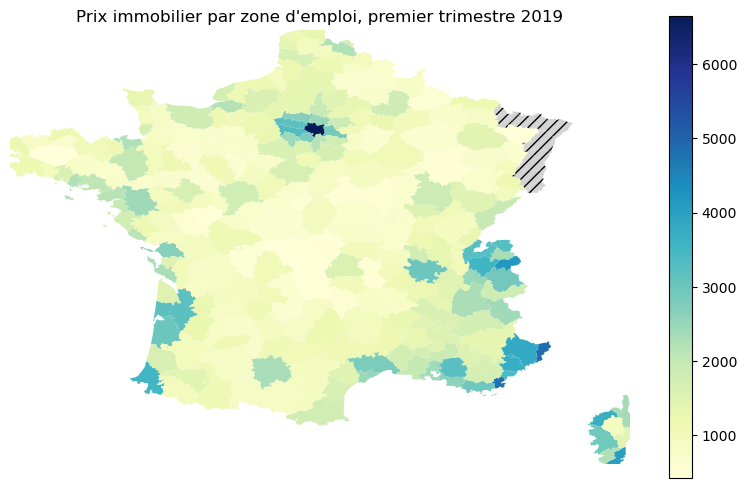

In [ ]:
plot_map(full_map[(full_map['Date'] == '20190101')|(full_map['Date'].isna())], 
         'prixM2', "Prix immobilier par zone d'emploi, premier trimestre 2019", 
         "YlGnBu")

On observe une très forte hétérogénéité des prix de l'immobillier en France. Les prix sont très élevées dans la zone d'emploi de Paris et plus largement dans l'Ouest de l'Ile-de-France, ainsi que dans la Côte d'Azur. On remarque également des prix élevés dans les zones d'emploi proches de la frontière Suisse. Cela est probablement dû à la présence de travailleurs frontaliers. 

Au contraire, les prix immobilier sont faibles dans les zones rurales, en particulier dans le centre de la France.

On note l'absence de données pour une partie de l'Alsace et la Lorraine.


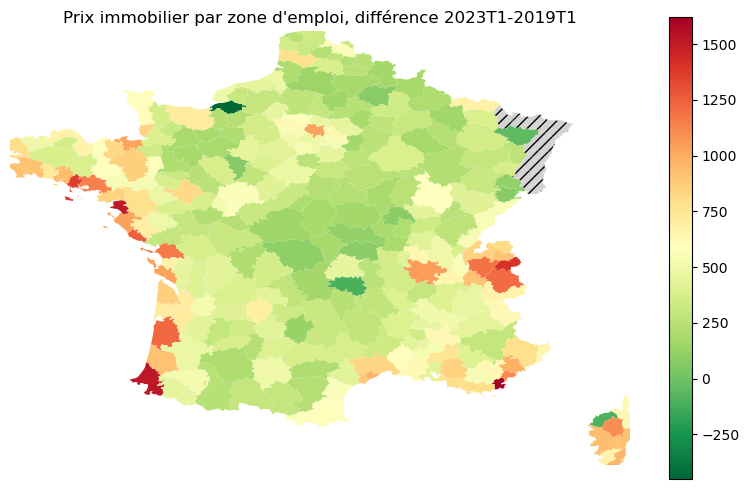

In [ ]:
plot_map(full_map[(full_map['Date'] == '20230101')|(full_map['Date'].isna())], 
         'dprix', "Prix immobilier par zone d'emploi, différence 2023T1-2019T1", 
         "RdYlGn_r")

Les prix de l'immobilier sont stables dans l'essentiel de la France. Cependant, certains territoires ont vu de fortes augmentations. Toutes les zones d'emplois situées sur la côte atlantique ont subi des augmentations importantes tout comme celles sur la côte de la méditerannées de la région PACA. On remarque aussi une forte augmentation dans les zones d'emplois proches de la frontière Suisse. Etonnamment, l'augmentation dans la zone d'emploi de Paris entre 2019 et 2023 n'est pas la plus élevée, elle s'élève à environ 1000 euros du mètre carré contre environ 1500 euros pour la zone d'emploi de Sainte Maxime. 

On note de même l'absence de données pour une partie de l'Alsace et la Lorraine.

In [ ]:
# Plotting time series
def plot_time_series(data, x, y, title, hue=None):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, hue=hue)
    plt.title(title)
    plt.show()

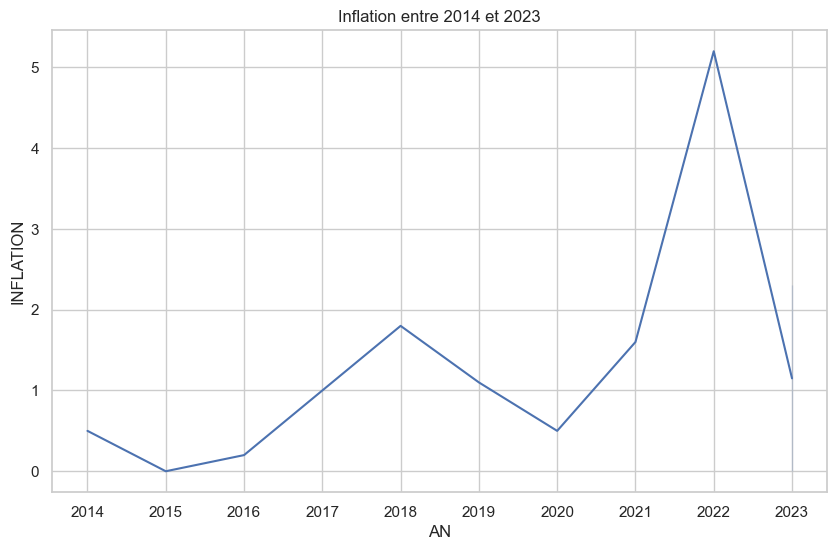

In [ ]:
plot_time_series(irflation, "AN", "INFLATION", "Inflation entre 2014 et 2023")

On observe qu'entre 2014 et 2016, la France a connu une inflation relativement basse. Puis, de 2016 à 2018, l'inflation a légèrement augmenté pour atteindre des niveaux plus proches de l'objectif de la Banque centrale européenne (BCE) qui vise une inflation inférieure mais proche de 2%. Ensuite, la crise du Covid en 2020 a de nouveau fait baisser l'inflation. En effet, les mesures de confinement ont contribué à une baisse de la demande et à une pression à la baisse des prix. Mais en 2022, l'inflation a fortement augmenté pour atteindre les 5%, cela est lié notamment à l'invasion de l'Ukraine par la Russie.

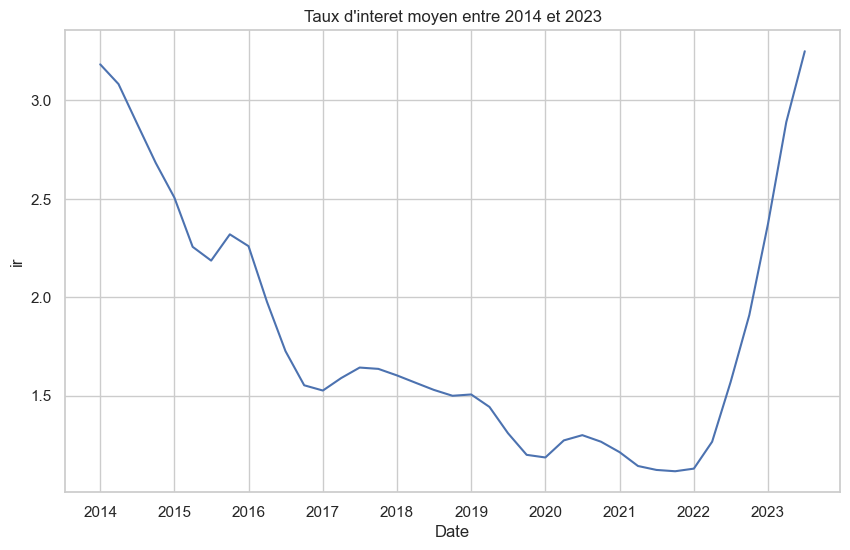

In [ ]:
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'], format='%Y%m%d')
plot_time_series(interest_rates, "Date", "ir", "Taux d'interet moyen entre 2014 et 2023")

Entre 2014 et 2017, les taux d'intérêt ont diminué. Puis, ils ont été relativement stables jusqu'en 2022, en raison de la faible inflation. A partir de 2022, les taux d'intérêt ont fortement augmenté pour atteindre les niveaux de 2014.

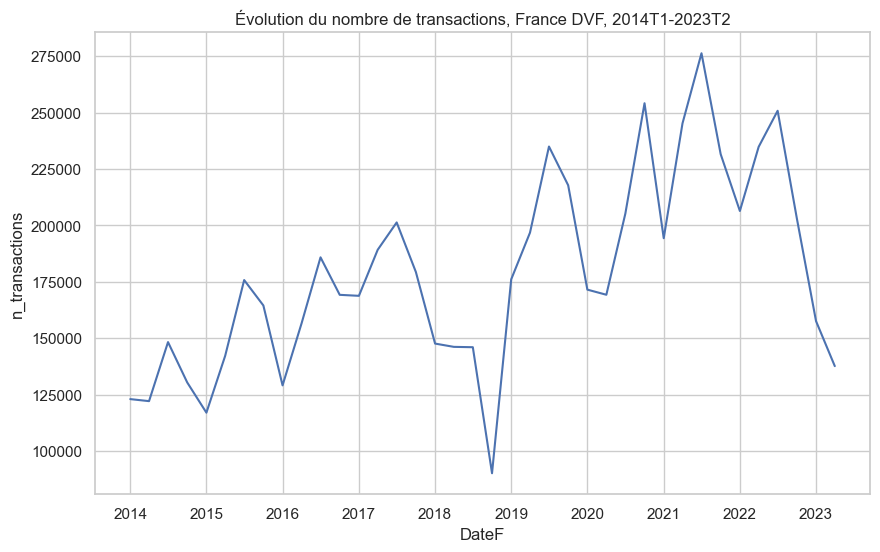

In [ ]:
immo_panel_com['DateF'] = pd.to_datetime(immo_panel_com['Date'], format='%Y%m%d')
immo_panel_com_grouped = immo_panel_com.groupby('DateF').agg({'n_transactions': 'sum'}).reset_index()
plot_time_series(immo_panel_com_grouped, 'DateF', 'n_transactions', 
                 "Évolution du nombre de transactions, France DVF, 2014T1-2023T2")

Il y a eu le plus de transactions immobilières entre 2021 et 2022, pour compenser probablement le ralentissement dû à la crise du Covid en 2020. A partir de 2022, le nombre de transactions immobilières s'est mis à baisser à cause notamment de la hausse des taux d'intérêt et de l'inflation.

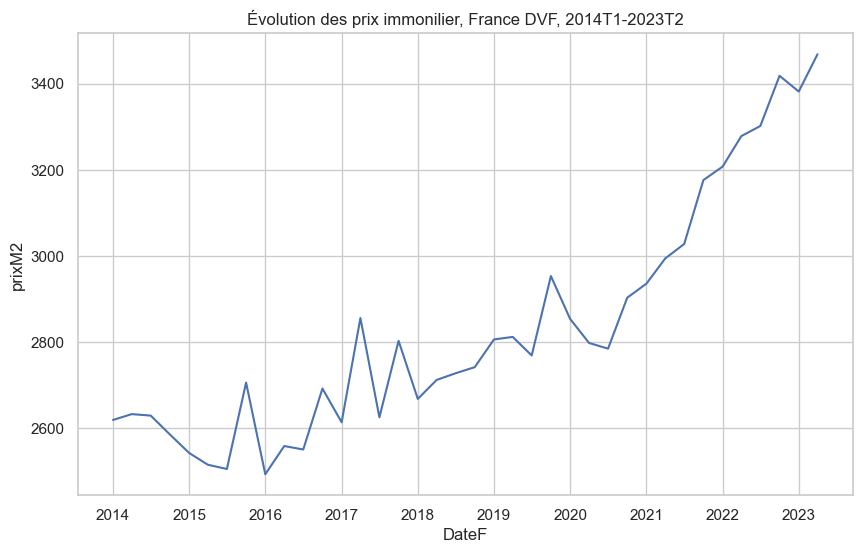

In [ ]:
immo_panel_full['DateF'] = pd.to_datetime(immo_panel_full['Date'], format='%Y%m%d')
plot_time_series(immo_panel_full, 'DateF', 'prixM2', 
                 "Évolution des prix immonilier, France DVF, 2014T1-2023T2")

De 2014 à 2023, les prix moyens de l'immobilier en France ont largement progressé avec une hausse de près de 30% entre 2014 et 2023 pour l'ensemble de la France. Cette hausse n'a cependant pas été linéaire et cache de fortes disparités territoriales puisque le prix de l'immobilier n'a pas suivi la même courbe de progression partout. 

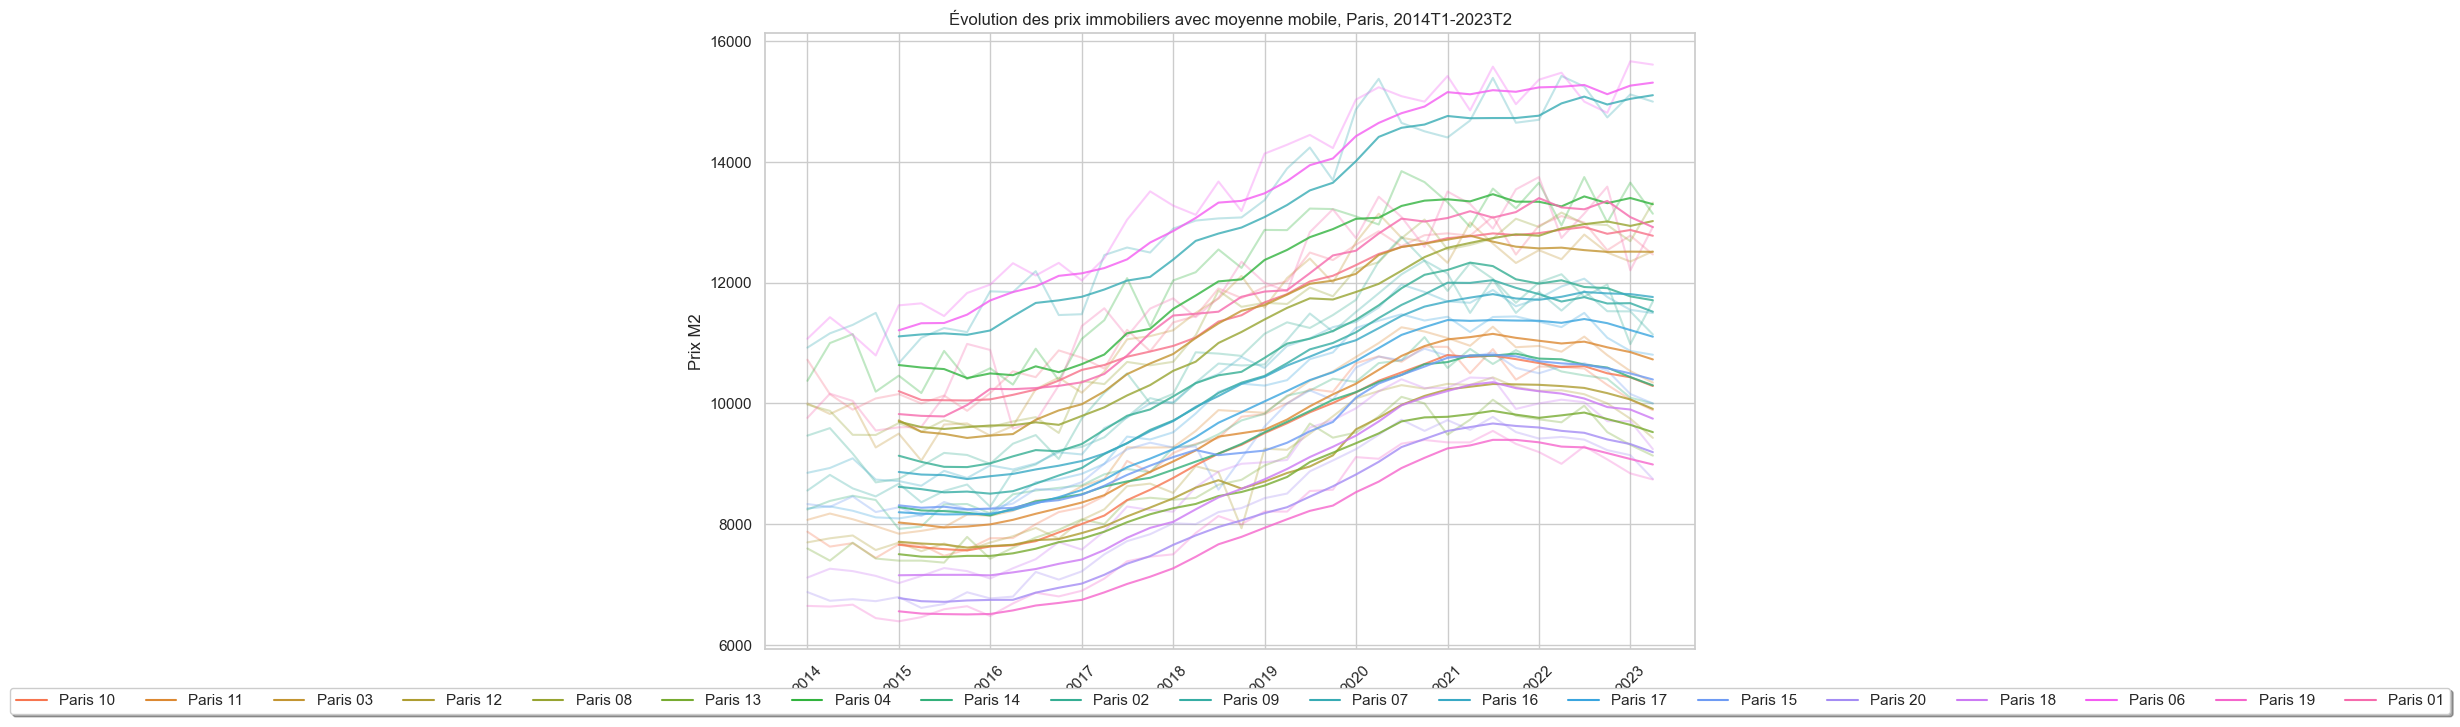

In [ ]:
# Evolution des prix parisiens ---
paris_data = immo_panel_com[immo_panel_com['LIB_COM'].str.startswith('Paris ')]
paris_data = paris_data.sort_values(by='DateF')
window_size = 5  
paris_data['Moving_Average'] = paris_data.groupby('LIB_COM')['prixM2'].transform(lambda x: x.rolling(window=window_size).mean())
plt.figure(figsize=(12, 8))
sns.lineplot(data=paris_data, x='DateF', y='prixM2', hue='LIB_COM', alpha=0.3)
sns.lineplot(data=paris_data, x='DateF', y='Moving_Average', hue='LIB_COM', alpha=0.8, legend=None)
plt.title('Évolution des prix immobiliers avec moyenne mobile, Paris, 2014T1-2023T2')
plt.xlabel('Date')
plt.ylabel('Prix M2')
plt.xticks(rotation=45)
sns.set_theme(style="whitegrid")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=len(paris_data['LIB_COM'].unique()))
plt.show()

## Partie II - Préparation des variables de contrôle

## 1. Récupération des données

### Chômage

In [14]:
#IMPORT UNEMPLOYMENT DATA
#source https://www.insee.fr/fr/statistiques/1893230
t_passage = pd.read_feather(path+"/data/interim/tble_de_passage_py.feather")[["COM","ZE","LIB_COM", "LIB_ZE", "EPCI", "LIB_EPCI"]].drop_duplicates()
unemployement = pd.read_excel(path+"/data/external/unemployment/chomage-zone-t1-2003-t3-2023.xlsx", 
                               sheet_name="txcho_ze", skiprows=5)
unemployement_long = pd.melt(unemployement, id_vars=['ZE2020', 'LIBZE2020', 'REG', 'LIBREG'],
                             var_name='Date', value_name='UNEMP')

In [15]:
def transform_date(date):
    if date.endswith('-T1'):
        return date[:4] + '0101'
    elif date.endswith('-T2'):
        return date[:4] + '0401'
    elif date.endswith('-T3'):
        return date[:4] + '0701'
    elif date.endswith('-T4'):
        return date[:4] + '1001'
    else:
        return pd.NA

In [16]:
unemployement_long['Date'] = unemployement_long['Date'].apply(transform_date)
unemployement_long = unemployement_long[pd.to_numeric(unemployement_long['Date'], errors='coerce') > 20131231]

In [17]:
unemployement_long.head()

,ZE2020,LIBZE2020,REG,LIBREG,Date,UNEMP
13288,51,Alençon,0,INTERRÉGIONAL,20140101,9.4
13289,52,Arles,0,INTERRÉGIONAL,20140101,13.4
13290,53,Avignon,0,INTERRÉGIONAL,20140101,12.3
13291,54,Beauvais,0,INTERRÉGIONAL,20140101,10.1
13292,55,Bollène-Pierrelatte,0,INTERRÉGIONAL,20140101,12.8


### Revenus

In [18]:
#IMPORT AVAILABLE INCOME DATA  
#source https://www.insee.fr/fr/statistiques/3126151
#source https://www.insee.fr/fr/statistiques/6036907

income2014 = pd.read_excel(path+"/data/external/revenus/indic-struct-distrib-revenu-2014-COMMUNES/indic-struct-distrib-revenu-2014-COMMUNES/FILO_DISP_COM.xls", 
                               sheet_name="ENSEMBLE", skiprows=5)
income2014 = income2014[["CODGEO","Q214"]]

income2019 = pd.read_excel(path+"/data/external/revenus/indic-struct-distrib-revenu-2019-COMMUNES/FILO2019_DISP_COM.xlsx", 
                               sheet_name="ENSEMBLE", skiprows=5)
income2019 = income2019[["CODGEO","Q219", "GI19"]]

In [21]:
#MERGE 
income2014_2019 = pd.merge(income2014, income2019, how='inner', on = ["CODGEO"])

In [22]:
#ADD column Mediane_evol_diff to observe the evolution of available income between 2019 and 2019
income2014_2019["med_change"] = income2014_2019["Q219"]/income2014_2019["Q214"]
income2014_2019["CODGEO"] = income2014_2019["CODGEO"].astype(str) #preventive bug correction

In [23]:
income2014_2019.head()

,CODGEO,Q214,Q219,GI19,med_change
0,01001,21576.666667,23970,NaN,1.110922
1,01002,21672.857143,23640,NaN,1.090765
2,01004,19756.111111,20510,0.290,1.038160
3,01005,23204.800000,24050,NaN,1.036423
4,01007,21679.333333,23380,0.206,1.078446


### Densité de population

In [24]:
#IMPORT POPULATION AND SURFACE
#https://www.insee.fr/fr/statistiques/7632565
population = pd.read_excel(path+"/data/external/pop_density/base-cc-serie-historique-2020.xlsx", 
                               sheet_name="COM_2020", skiprows=5)[["CODGEO","P20_POP","P14_POP", "SUPERF"]]
population = population[~population['CODGEO'].isin(["75056", "69123", "13055"])]  #Remove Paris, Lyon, Marseille                             
                               
population_arr = pd.read_excel(path+"/data/external/pop_density/base-cc-serie-historique-2020.xlsx", 
                               sheet_name="ARM_2020", skiprows=5)[["CODGEO","P20_POP","P14_POP", "SUPERF"]]

population_arr.loc[population_arr['CODGEO'] == "75112", 'SUPERF'] = 6.37 #correct for Bois de Vincennes
population_arr.loc[population_arr['CODGEO'] == "75116", 'SUPERF'] = 7.91 #correct for Bois de Boulogne


In [25]:
densite = pd.concat([population, population_arr], axis=0, ignore_index=True)
#create popdensity2014 and popdensity2020 : population/surface
densite["popdensity2014"] = densite["P14_POP"] / densite["SUPERF"]
densite["popdensity2020"] = densite["P20_POP"] / densite["SUPERF"]
densite["CODGEO"] = densite["CODGEO"].astype(str) #preventive bug correction

In [26]:
densite.head()

,CODGEO,P20_POP,P14_POP,SUPERF,popdensity2014,popdensity2020
0,01001,806,767,15.95,48.087774,50.532915
1,01002,262,239,9.15,26.120219,28.633880
2,01004,14288,14022,24.60,570.000000,580.813008
3,01005,1782,1627,15.92,102.198492,111.934673
4,01006,113,109,5.88,18.537415,19.217687


In [28]:
#MERGE INCOME2014_2019 AND DENSITE
control_var = pd.merge(income2014_2019,densite,how="inner",on=["CODGEO"])

### Accessibilité aux médecins généralistes

In [30]:
#IMPORT PHYSICISTS accessibility
#source https://data.drees.solidarites-sante.gouv.fr/explore/dataset/530_l-accessibilite-potentielle-localisee-apl/information/
physicist = pd.read_excel(path+"/data/external/physicist/Indicateur d'accessibilité potentielle localisée (APL) aux médecins généralistes.xlsx",sheet_name="APL_2019", skiprows=8)
physicist = physicist[["Code commune INSEE","APL aux médecins généralistes de moins de 65 ans"]]
#renaming variables 
physicist = physicist.rename(columns ={"Code commune INSEE": "CODGEO", "APL aux médecins généralistes de moins de 65 ans" : "Physicist_access"})
physicist = physicist.dropna()


In [24]:
physicist.head()

,CODGEO,Physicist_access
1,01001,2.289
2,01002,2.802
3,01004,4.469
4,01005,4.137
5,01006,0.775


In [31]:
#MERGE
control_var = pd.merge(control_var,physicist,how="inner",on="CODGEO")

### Taux de criminalité

In [26]:
#IMPORT CRIMINALITY
#source (not compressed version) https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-et-departementale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/#/resources
criminality = pd.read_csv(path+"/data/external/criminality/donnee-data.gouv-2022-geographie2023-produit-le2023-07-17.csv",sep=",")
criminality = criminality.rename(columns = {"CODGEO_2023":"CODGEO"})
criminality['tauxpourmille'] = criminality['tauxpourmille'].fillna(criminality['complementinfotaux'])
criminality19 = criminality[criminality["annee"].isin([19])]
criminality19['tauxpourmille'] = criminality19['tauxpourmille'].str.replace(",", ".").astype(float)

C:\Users\lujul\AppData\Local\Temp\ipykernel_13576\413589487.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  criminality = pd.read_csv(path+"/data/external/criminality/donnee-data.gouv-2022-geographie2023-produit-le2023-07-17.csv",sep=",")


In [27]:
burglary19 = criminality19[criminality19["classe"].isin(["Cambriolages de logement"])] #around 70% of Nan in the column tauxpourmille
burglary19 = burglary19[["CODGEO","tauxpourmille"]]
burglary19 = burglary19.rename(columns = {"tauxpourmille":"burglary_for_1000"})

In [28]:
burglary19.head()

,CODGEO,burglary_for_1000
24043,01001,7.926047
24044,01002,7.926047
24045,01004,10.197461
24046,01005,14.944643
24047,01006,7.926047


In [29]:
assault19 = criminality19[criminality19["classe"].isin(["Coups et blessures volontaires"])] #around 60% of Nan in the column faits (number of occurence)
assault19= assault19[["CODGEO","tauxpourmille"]]
assault19 = assault19.rename(columns = {"tauxpourmille":"assault_for_1000"})

In [30]:
assault19.head()

,CODGEO,assault_for_1000
56283,01001,1.738796
56284,01004,7.499646
56285,01005,1.738796
56286,01006,1.738796
56287,01007,1.738796


In [31]:
otherassault19 = criminality19[criminality19["classe"].isin(["Autres coups et blessures volontaires"])] #around 45% of Nan in the column faits (number of occurence)
otherassault19= otherassault19[["CODGEO","tauxpourmille"]]
otherassault19 = otherassault19.rename(columns = {"tauxpourmille":"other_assault_for_1000"})

In [32]:
otherassault19.head()

,CODGEO,other_assault_for_1000
0,01001,0.000000
1,01004,4.386586
2,01005,0.987374
3,01006,0.987374
4,01007,0.987374


In [33]:
destruction19 = criminality19[criminality19["classe"].isin(["Destructions et dégradations volontaires"])] #around 70% of Nan in the column faits (number of occurence)
destruction19 = destruction19[["CODGEO","tauxpourmille"]]
destruction19 = destruction19.rename(columns = {"tauxpourmille":"destruction_for_1000"})

In [34]:
destruction19.head()

,CODGEO,destruction_for_1000
87006,01001,3.704983
87007,01002,3.704983
87008,01004,9.551436
87009,01005,3.704983
87010,01006,3.704983


In [35]:
#MERGE WITH control_var
control_var = pd.merge(control_var,burglary19,how="left",on="CODGEO")
control_var = pd.merge(control_var,assault19,how="left",on="CODGEO")
control_var = pd.merge(control_var,otherassault19,how="left",on="CODGEO")
control_var = pd.merge(control_var,destruction19,how="left",on="CODGEO")

## 2. Création d'une table de contrôle

In [36]:
#MERGE WITH TABLE DE PASSAGE
control_var = pd.merge(t_passage,control_var,how="right",right_on="CODGEO", left_on="COM")

In [37]:
control_var.head()

,COM,ZE,LIB_COM,LIB_ZE,EPCI,LIB_EPCI,CODGEO,Q214,Q219,GI19,...,P20_POP,P14_POP,SUPERF,popdensity2014,popdensity2020,Physicist_access,burglary_for_1000,assault_for_1000,other_assault_for_1000,destruction_for_1000
0,01001,8405.0,L'Abergement-Clémenciat,Bourg en Bresse,8405,CC de la Dombes,01001,21576.666667,23970,NaN,...,806,767,15.95,48.087774,50.532915,2.289,7.926047,1.738796,0.000000,3.704983
1,01002,8405.0,L'Abergement-de-Varey,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01002,21672.857143,23640,NaN,...,262,239,9.15,26.120219,28.633880,2.802,7.926047,0.000000,0.000000,3.704983
2,01004,8405.0,Ambérieu-en-Bugey,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01004,19756.111111,20510,0.290,...,14288,14022,24.60,570.000000,580.813008,4.469,10.197461,7.499646,4.386586,9.551436
3,01005,8434.0,Ambérieux-en-Dombes,Villefranche-sur-Saône,8434,CC Dombes Saône Vallée,01005,23204.800000,24050,NaN,...,1782,1627,15.92,102.198492,111.934673,4.137,14.944643,1.738796,0.987374,3.704983
4,01007,8405.0,Ambronay,Bourg en Bresse,8405,CC de la Plaine de l'Ain,01007,21679.333333,23380,0.206,...,2827,2570,33.55,76.602086,84.262295,4.714,15.860428,1.738796,0.987374,6.785714


**Définition des variables** 

| Variable | Description  |  Source | 
|---|---|---|
| Q214   | Revenu disponible médian par unité de consommation en 2014 (€)  | INSEE  | 
| Q219   | Revenu disponible médian par unité de consommation en 2014 (€) | INSEE  | 
| GI19   | Indice de Gini en 2019  | INSEE  | 
| popdensity2014   | Densité de population en 2014 (nombre d'habitants/surface)   | INSEE  | 
| popdensity2020   | Densité de population en 2020 (nombre d'habitants/surface)  | INSEE  | 
| Physicist_access   | Indicateur d'ccessibilité potentielle localisée (APL) aux médecins généralistes* | Ministère de la santé  | 
| burglary_for_1000   | Nombre de cambriolages pour 1000 habitants en 2019  | Ministère de l'intérieur  | 
| assault_for_1000   | Nombre de coups et blessures volontaires pour 1000 habitants en 2019  | Ministère de l'intérieur  | 
| other_assault_for_1000   | Nombre d'autres coups et blessures volontaires pour 1000 habitants en 2019   | Ministère de l'intérieur  | 
| destruction_for_1000  | Nombre de destructions et dégradations volontaires pour 1000 habitants en 2019   | Ministère de l'intérieur  | 

*DREES: "L’indicateur d’accessibilité potentielle localisée (APL) a été développé pour mesurer l’adéquation spatiale entre l’offre et la demande de soins de premier recours à un échelon géographique fin. C'est un indicateur local, disponible au niveau de chaque commune, qui tient compte de l’offre et de la demande issues des communes environnantes. Calculé à l’échelle communale, l’APL met en évidence des disparités d’offre de soins qu’un indicateur usuel de densité, calculé sur des mailles beaucoup plus larges aurait tendance à masquer. Il tient également compte du niveau d’activité des professionnels en exercice ainsi que de la structure par âge de la population de chaque commune qui influence les besoins de soins."

In [61]:
# Writing output
feather.write_feather(control_var, path+"/data/interim/TI_controls.feather")
feather.write_feather(unemployement_long, path+"/data/interim/TV_controls.feather")

## 3. Visualisation des données de contrôle

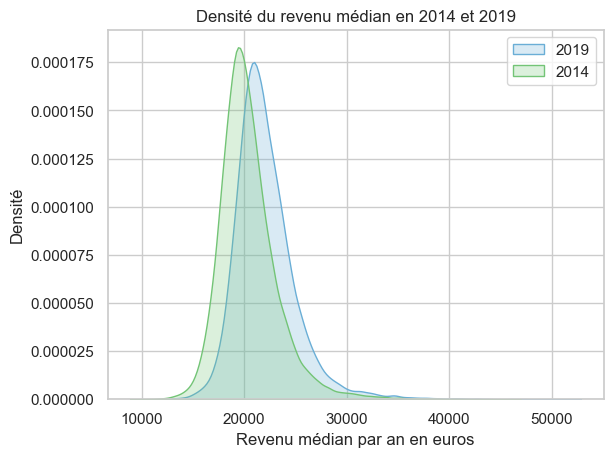

In [33]:
#Densité de revenus en 2019 par commune
sns.kdeplot(income2019[["Q219"]], fill=True, label= "2019",palette='Blues')
sns.kdeplot(income2014[["Q214"]], fill=True, label = "2014",palette='Greens')
plt.xlabel('Revenu médian par an en euros')
plt.ylabel('Densité')
plt.legend()
plt.title("Densité du revenu médian en 2014 et 2019")
plt.show()

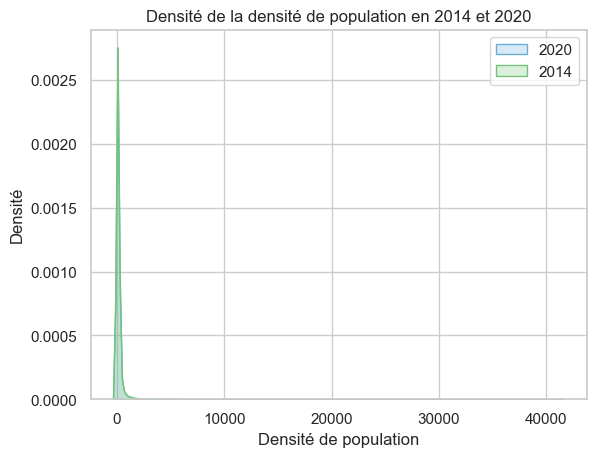

In [34]:
#Densité de population en 2014 et 2020 par commune
sns.kdeplot(densite[["popdensity2020"]], fill=True, label= "2020",palette='Blues')
sns.kdeplot(densite[["popdensity2014"]], fill=True, label = "2014",palette='Greens')
plt.xlabel('Densité de population')
plt.ylabel('Densité')
plt.legend()
plt.title('Densité de la densité de population en 2014 et 2020')
plt.show()

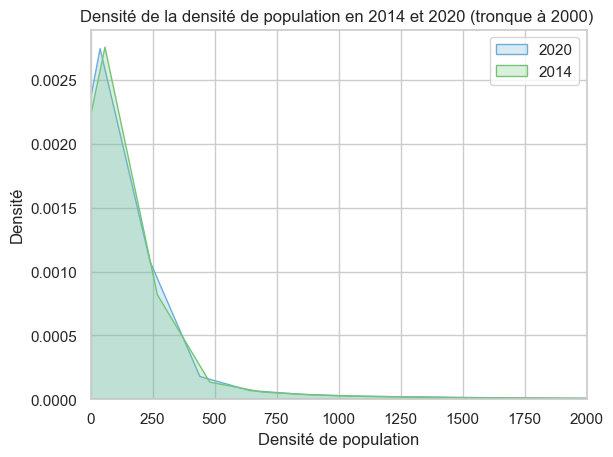

In [35]:
#Densité de population en 2014 et 2020 par commune avec plot tronqué
plt.subplot
sns.kdeplot(densite[["popdensity2020"]], fill=True, label= "2020",palette='Blues')
sns.kdeplot(densite[["popdensity2014"]], fill=True, label = "2014",palette='Greens')
plt.xlabel('Densité de population')
plt.ylabel('Densité')
plt.legend()
plt.title('Densité de la densité de population en 2014 et 2020 (tronque à 2000) ')
plt.xlim(0,2000)
plt.show()

## Partie III - Analyse, modélisation et économétrie

Dans cette section consacrée à la modélisation, nous ferons appel à des méthodes économétriques afin de tenter de répondre à la problématique centrale de ce projet : dans quelle mesure la hausse récente des taux d'intérêt impacte-t-elle différemment les marchés immobiliers locaux en fonction des caractéristiques de chaque ville ?

Comme mentionné dans les sections précédentes, la disponibilité des variables d'intérêt sous une forme évolutive dans le temps est limitée, ce qui contraint l'usage de méthodes de séries temporelles en panel telles que les PVAR. Par conséquent, nous privilégions des méthodes classiques d'économétrie de panel, telles que les modèles à effets fixes.

Le modèle principal de cette analyse est un modèle à effets fixes. Il intègre comme variables d'intérêt le retard (lag) du taux d'intérêt en interaction avec différentes caractéristiques locales, tout en contrôlant les effets annuels et la structure des transactions effectuées. Des modèles supplémentaires à différents niveaux géographiques sont estimés pour tester la robustesse de nos résultats.

Les prix immobiliers utilisés sont exprimés, sauf indication contraire, en euros 2014.

In [72]:
# Custom Functions
def merge_and_transform(base_df, irflation_df, control_df, base_col, min_transactions=30, required_count=38):
    base_df=base_df.drop(columns=["LIB_"+base_col])
    df = base_df[base_df['n_transactions'] > min_transactions]
    df['n'] = df.groupby(base_col)[base_col].transform('count')
    df = df[df['n'] == required_count].drop(columns='n')
    df = df.merge(irflation_df, on='Date', how='left')
    df = df.merge(control_df, on=base_col, how='left')
    df['prixM2'] = df['prixM2'] / df['BASE14']
    df['log_prixM2'] = np.log(df['prixM2'])
    df['Q219'] = df['Q219'] / irflation['BASE14'][20]
    df['med_change'] = (df['Q219'] / irflation_df['BASE14'][20]) - (df['Q214'] / irflation_df['BASE14'][0])
    df['dens_change'] = df['popdensity2020'] - df['popdensity2014']
    return df

In [73]:
def group_and_calculate_diff(df, group_cols):
    df = df.sort_values(by=group_cols + ['Date'])
    grouped = df.groupby(group_cols)
    df['diff_prixM2'] = grouped['prixM2'].diff().fillna(np.nan)
    df['diff2_prixM2'] = grouped['prixM2'].diff().diff().fillna(np.nan)
    df['year'] = df['Date'].str[:4]
    df['trim'] = df['Date'].str[5:6]
    df['diff2_prop_maison'] = grouped['prop_maison'].diff().fillna(np.nan)
    df['diff_ir'] = grouped['ir'].diff().fillna(np.nan)
    df['lag_ir'] = grouped['ir'].shift(1)
    df['lag2_ir'] = grouped['ir'].shift(2)
    df['lag3_ir'] = grouped['ir'].shift(3)
    df['lag4_ir'] = grouped['ir'].shift(4)
    df['diff_lag_ir'] = grouped['lag_ir'].diff().fillna(np.nan)
    df['diff2_lag_ir'] = grouped['lag_ir'].diff().diff().fillna(np.nan)
    
    for var in ['popdensity2020', 'med_change', 'Physicist_access', 'Q219', 'prop_maison', 'assault_for_1000', 'dens_change']:
      df[f'lag3_ir_{var}'] = df['lag3_ir'] * df[var]
    df['prixM2_FE'] = grouped['prixM2'].transform(lambda x: x - x.mean()) #Within transformation
    df['log_prixM2_FE'] = grouped['log_prixM2'].transform(lambda x: x - x.mean()) #Within transformation
    df['lag3_ir_FE'] = grouped['lag3_ir'].transform(lambda x: x - x.mean()) #Within transformation
    df['prop_maison_FE'] = grouped['prop_maison'].transform(lambda x: x - x.mean()) #Within transformation
    df['popdensity2020_ir_FE'] = grouped['lag3_ir_popdensity2020'].transform(lambda x: x - x.mean()) #Within transformation
    df['med_change_ir_FE'] = grouped['lag3_ir_med_change'].transform(lambda x: x - x.mean()) #Within transformation
    df['Physicist_access_ir_FE'] = grouped['lag3_ir_Physicist_access'].transform(lambda x: x - x.mean()) #Within transformation
    df['Q219_ir_FE'] = grouped['lag3_ir_Q219'].transform(lambda x: x - x.mean()) #Within transformation
    df['prop_maison_ir_FE'] = grouped['lag3_ir_prop_maison'].transform(lambda x: x - x.mean()) #Within transformation
    df['assault_for_1000_ir_FE'] = grouped['lag3_ir_assault_for_1000'].transform(lambda x: x - x.mean()) #Within transformation
    df['dens_change_ir_FE'] = grouped['lag3_ir_dens_change'].transform(lambda x: x - x.mean()) #Within transformation
    return df.reset_index(drop=True)

In [64]:
def run_regression(df, formula):
    model = smf.ols(formula, data=df)
    results = model.fit()
    return(results)

In [65]:
def aggregate_data(df, group_cols, agg_dict):
    agg_df = df.groupby(group_cols).agg(agg_dict).reset_index()
    agg_df['popdensity2020'] = agg_df['P20_POP'] / agg_df['SUPERF']
    agg_df['popdensity2014'] = agg_df['P14_POP'] / agg_df['SUPERF']
    return agg_df.drop(columns=['P20_POP', 'P14_POP', 'SUPERF'])

In [94]:
def corplot(df, nom):
  plt.figure(figsize=(10, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm')
  plt.title('Correlations intra-ville pour '+nom)
  plt.show()

In [67]:
def cor_ville(df, nom):
  df = df[df['LIB_COM']==nom]
  df = df[["prixM2", "ir","lag_ir","lag2_ir","lag3_ir","lag4_ir", "prop_maison"]].dropna().corr()
  return(df)

In [68]:
# Reading Data
base_path = path + "/data/interim/"
immo_epci = pd.read_feather(base_path + "immo_panel_epci_py.feather")
immo_ze = pd.read_feather(base_path + "immo_panel_ze_py.feather")
immo_com = pd.read_feather(base_path + "immo_panel_com_py.feather")
immo_full = pd.read_feather(base_path + "immo_panel_full_py.feather")
unemployment = pd.read_feather(base_path + "TV_controls.feather")
control = pd.read_feather(base_path + "TI_controls.feather")
irflation = pd.read_feather(base_path + "irflation.feather")

In [74]:
# Aggregate data
agg_dict_control = {
    'Q219': 'mean', 'Q214': 'mean',
    'P20_POP': 'sum', 'P14_POP': 'sum',
    'SUPERF': 'sum', 'Physicist_access': 'mean',
    'assault_for_1000': 'mean'
}
control_ze = aggregate_data(control, ['ZE', 'LIB_ZE'], agg_dict_control)
control_epci = aggregate_data(control, ['EPCI', 'LIB_EPCI'], agg_dict_control)

In [70]:
control_ze

,ZE,LIB_ZE,Q219,Q214,Physicist_access,assault_for_1000,popdensity2020,popdensity2014
0,51.0,Alençon,20997.962963,19513.189514,2.082500,1.755776,55.113269,56.711867
1,52.0,Arles,21809.000000,19972.087654,3.420800,3.236450,72.920998,73.127843
2,53.0,Avignon,22300.000000,20545.182303,3.394056,2.740536,417.644716,410.739621
3,54.0,Beauvais,22776.977492,21354.075800,2.484302,2.126033,101.060545,99.605781
4,55.0,Bollène-Pierrelatte,22470.000000,20853.342050,2.636862,2.360175,116.635591,114.159934
...,...,...,...,...,...,...,...,...
292,9403.0,Calvi,20157.692308,17556.055940,2.501885,2.770986,30.841287,29.282792
293,9404.0,Corte,19877.619048,18417.861064,2.302619,2.429574,17.854459,17.851954
294,9405.0,Ghisonaccia,19199.500000,17423.182708,1.318500,2.395572,21.200251,20.658202
295,9406.0,Porto-Vecchio,20430.000000,18183.271573,3.065545,3.696087,29.525449,28.948056


In [75]:
# Processing for immo_reg_com
immo_reg_com = merge_and_transform(immo_com, irflation, control, 'COM')
immo_reg_com_diff = group_and_calculate_diff(immo_reg_com, ['COM'])

C:\Users\lujul\AppData\Local\Temp\ipykernel_10052\1508454723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n'] = df.groupby(base_col)[base_col].transform('count')


In [76]:
# Processing for immo_reg_ze
immo_reg_ze = merge_and_transform(immo_ze, irflation, control_ze, 'ZE')
immo_reg_ze_diff = group_and_calculate_diff(immo_reg_ze, ['ZE', 'LIB_ZE'])
immo_reg_ze_diff = immo_reg_ze_diff.merge(unemployment[['ZE2020', 'Date', 'UNEMP']], left_on=['ZE', 'Date'], right_on=['ZE2020', 'Date'], how='left')
immo_reg_ze_diff['lag3_UNEMP'] = immo_reg_ze_diff.groupby(['ZE', 'LIB_ZE'])['UNEMP'].shift(3)
immo_reg_ze_diff['lag3_UNEMP_ir'] = immo_reg_ze_diff['lag3_UNEMP']*immo_reg_ze_diff['lag3_ir'] 
grouped = immo_reg_ze_diff.groupby(['ZE', 'LIB_ZE'])
immo_reg_ze_diff['lag3_UNEMP_FE'] = grouped['lag3_UNEMP'].transform(lambda x: x - x.mean()) #Within transformation
immo_reg_ze_diff['lag3_UNEMP_ir_FE'] = grouped['lag3_UNEMP_ir'].transform(lambda x: x - x.mean()) #Within transformation

C:\Users\lujul\AppData\Local\Temp\ipykernel_10052\1508454723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n'] = df.groupby(base_col)[base_col].transform('count')


In [77]:
# Processing for immo_reg_epci
immo_reg_epci = merge_and_transform(immo_epci, irflation, control_epci, 'EPCI')
immo_reg_epci_diff = group_and_calculate_diff(immo_reg_epci, ['EPCI', 'LIB_EPCI'])

C:\Users\lujul\AppData\Local\Temp\ipykernel_10052\1508454723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n'] = df.groupby(base_col)[base_col].transform('count')


### 1. Test de Granger

Le marché immobilier, étant moins liquide que les marchés financiers, ne révèle l'impact du taux d'intérêt sur les prix qu'après un certain délai. Il est courant dans la littérature de considérer le retard du taux d'intérêt plutôt que le taux lui-même, comme illustré par Harris (1989) dans _The Effect of Real Rates of Interest on Housing Prices_. Cependant, cette transmission varie selon les caractéristiques des marchés immobiliers et le contexte macroéconomique. Ainsi, pour déterminer le nombre approprié de retards du taux d'intérêt dans l'analyse des marchés locaux en France, nous employons un test de Granger. Ce test évalue si une série temporelle améliore la prédiction d'une autre série temporelle et, par conséquent, si elle est pertinente pour son analyse. $$\Delta ({p}/m^{2})_t \sim \Delta L^n(i_t)$$ Nous cherchons à déterminer si l'utilisation du taux d'intérêt avec plusieurs retards apporte des informations sur les prix immobiliers. L'hypothèse nulle est l'absence de pouvoir prédictif. Pour obtenir des séries stationnaires, nous utilisons la différence. Bien qu'il existe des méthodes pour généraliser le test de Granger à des données en panel (Holtz-Eakin et al., 1988), celles-ci n'ont pas été développées en Python. Pour obtenir une idée générale du nombre de retards requis, nous appliquons le test à quelques villes de tailles variées choisies aléatoirement.

In [78]:
# Granger Causality Test
for i in ["Paris 14","Clermont-Ferrand","Le Grau-du-Roi", "Cagnes-sur-Mer", "Savigny-sur-Orge"]:
  print(i)
  granger_test3 = grangercausalitytests(immo_reg_com_diff[immo_reg_com_diff["LIB_COM"]==i][['diff_prixM2', 'diff_ir']].dropna(), maxlag=5, verbose=True)

Paris 14

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7132  , p=0.0372  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=5.1417  , p=0.0234  , df=1
likelihood ratio test: chi2=4.8061  , p=0.0284  , df=1
parameter F test:         F=4.7132  , p=0.0372  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9161  , p=0.1648  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=4.4709  , p=0.1069  , df=2
likelihood ratio test: chi2=4.2075  , p=0.1220  , df=2
parameter F test:         F=1.9161  , p=0.1648  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8979  , p=0.0533  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=10.9478 , p=0.0120  , df=3
likelihood ratio test: chi2=9.4908  , p=0.0234  , df=3
parameter F test:         F=2.8979  , p=0.0533  , df_denom=27, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7984  , p=0.162

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Il apparaît que, selon la commune, si un effet existe, entre 1 et 3 trimestres sont nécessaires pour que le taux d'intérêt ait un pouvoir explicatif sur les prix immobiliers.

### 2. Corrélations

Afin d'observer les interactions entre les variables d'intérêt choisies et d'obtenir une première impression de ce que la modélisation peut apporter, il est utile de construire des matrices de corrélations. D'abord, une matrice pour l'ensemble du panel, puis pour les trois premières villes utilisées lors du test de Granger.

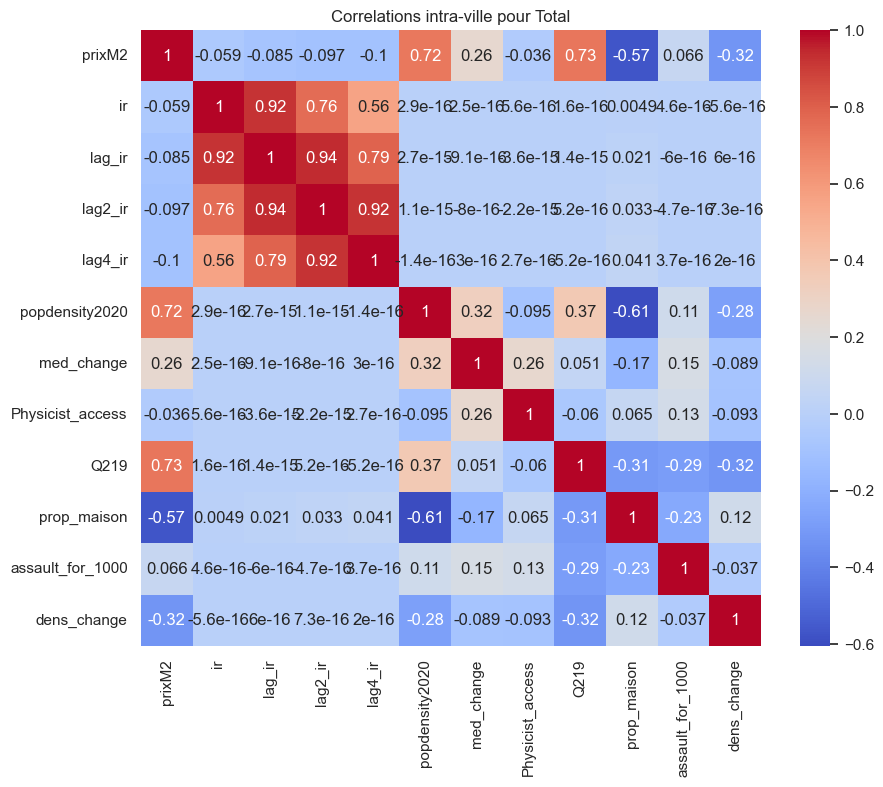

In [92]:
# Total 
immo_reg_corr =immo_reg_com_diff[["prixM2", "ir","lag_ir","lag2_ir","lag4_ir","popdensity2020", "med_change", "Physicist_access", "Q219", "prop_maison", "assault_for_1000", "dens_change"]].dropna().corr()
corplot(immo_reg_corr, "Total")

Cette matrice révèle une corrélation relativement faible entre les prix et le taux d'intérêt, quel que soit le nombre de retards. En revanche, les corrélations sont significatives entre les prix et la densité en 2020, l'évolution des revenus médians dans la commune, la proportion de maisons dans le total des transactions, et les changements de densité. La faible corrélation entre le taux d'intérêt et les prix s'explique probablement par la dimension NN de notre panel, bien plus importante que la dimension TT, le taux d'intérêt étant identique pour toutes les villes à chaque période.

Pour vérifier cela, il est possible d'établir des matrices de corrélations pour quelques villes, en excluant les variables constantes dans le temps. Par exemple, pour le 14e arrondissement de Paris : 

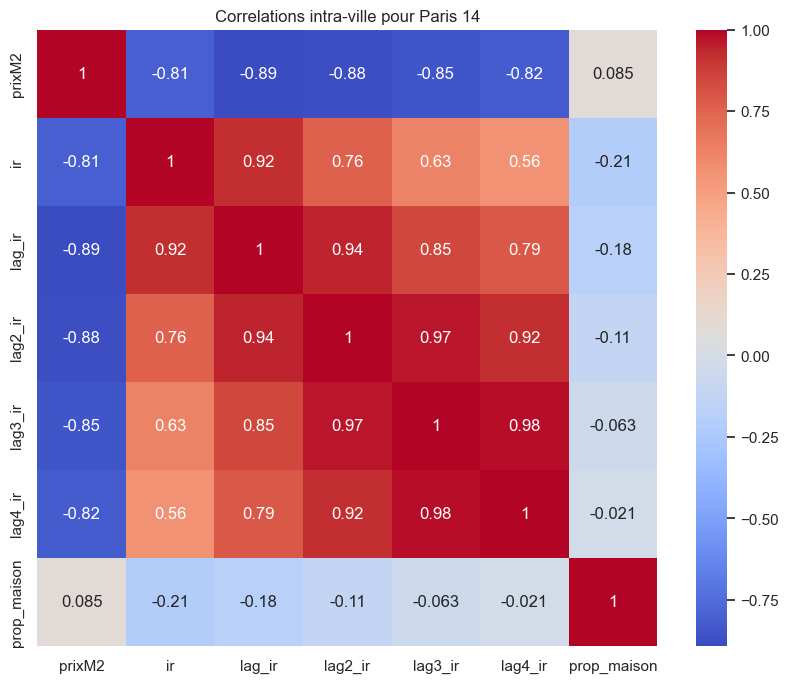

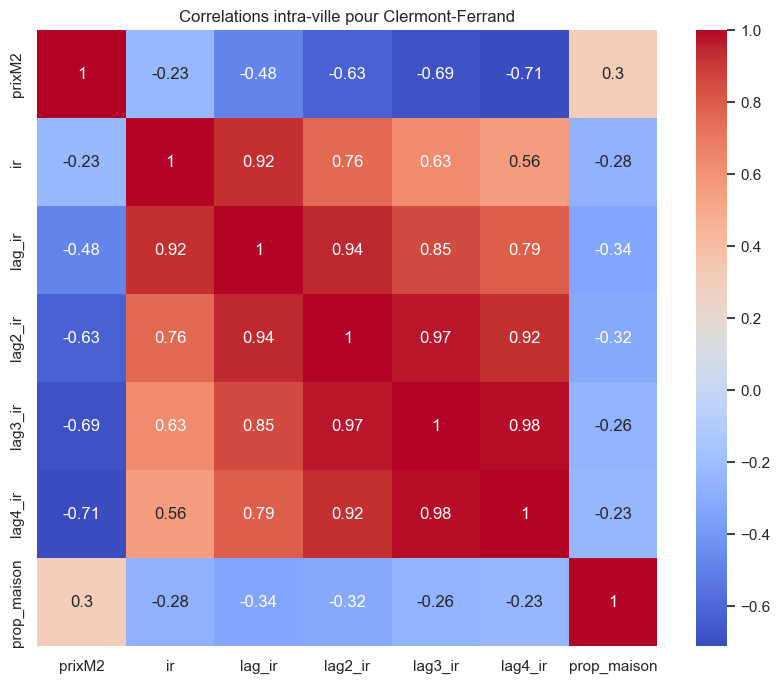

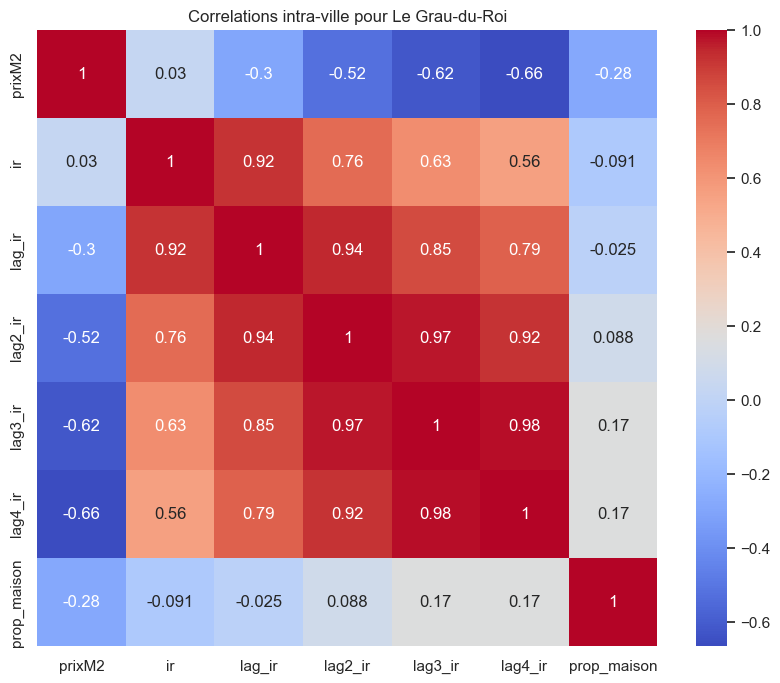

In [93]:
# Intra villes
for i in ["Paris 14","Clermont-Ferrand","Le Grau-du-Roi"]:
  corplot(cor_ville(immo_reg_com_diff, i), i)

Les corrélations avec le taux d'intérêt sont plus fortes, toujours négatives, et généralement plus élevées dans les deux villes de taille supérieur. De plus, la corrélation est plus forte au premier retard à Paris, tandis que pour Clermont-Ferrand et le Grau-du-Roi, elle est plus importante au troisième retard. Cela pourrait indiquer un effet différencié du taux d'intérêt selon la taille de la ville.


### 3. Modèles communaux

Nous sommes en présence de données de panel qui posent donc différents problème à l'estimateur OLS (MCO en français) dans ce contexte souvent appelé Pooled-OLS (voir _On The Pooling Of Time Series And Cross Section Data_ Yair Mundlak, 1978). Deux méthodes souvent utilisées pour résoudre les problèmes de POLS sont l'estimation avec fixed-effects ou random-effects. Un modèle à effets fixes semble préférable dans le cadre de ce projet, car il permet d'évaluer les variations intra-groupe en controlant pour toute l'hétérogéinité innobservable constante dans le temps (par exemple une rivière est présente dans la ville), c'est également un choix assez commun dans la littérature du pricing immobilier.  Pour plus de détails sur la méthodologie générale de travail sur des données de panel voir _Econometric Analysis of Cross Section and Panel Data_ Wooldridge, 2001.

#### Modèle Introductif - Modèle simple du taux d'intérêt

Pour introduire le modèle principal une régression simple est réalisée via un pooled-OLS sans effets croisés (l'utilisation d'effets fixes est pour l'instant impossible car cela controlerait pour toute l'hétérogéinité innobservable constante dans le temps par individu et certaines de nos variables explicatives sont constantes dans le temps) : $$p_{nt}= \beta_0+\beta_iL^3(i_t)+\beta_MM_{nt} + \beta_c X_{nc}+\beta_{D}D+\varepsilon_t$$ avec $p_{nt}$ le prix des appartements et maisons dans ville $n$ à la période t, $L^3(i_t)$ le troisième retard du taux d'interet à la période t, $M_{nt}$ la proportion de maisons dans le total des transactions immobilières à la période t pour la ville n, $X_{nc}$ la matrice des variables des contrôles constante dans le temps pour la ville $n$ (densité de population en km2 en 2019, revenus médian en 2019, accès à un médecin généraliste, taux d'agressions pour 1000, et la différence de densité et de revenus entre respectivement, 2020/2014 et 2019/2014). $D$ est une variable muette servant à controler les effets fixes de chaque trimestre (par exemple, la situation macroéconomique nationale ou les confinements pendant la période covid). 

Ainsi, cette régression a pour objectif de vérifier la cohérence des résultats et d'identifier certains problèmes de données (par exemple des valeurs manquantes au niveau des arrondissements de Paris, Lyon ou Marseille). 

In [83]:
# Model 1a
model1a= 'prixM2 ~ lag3_ir + (popdensity2020 + med_change + Physicist_access + Q219 + prop_maison + assault_for_1000 + dens_change) + prop_maison + C(Date)'
mod1a = run_regression(immo_reg_com_diff, model1a)
test_breuschpagan = het_breuschpagan(mod1a.resid,  mod1a.model.exog)
test_breuschpagan

(44.2594354358094, 0.5032122195850851, 1.0797340660837076, 0.335822077966434)

In [84]:
mod1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 prixM2   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1146.
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:22:01   Log-Likelihood:                -86456.
No. Observations:               10395   AIC:                         1.730e+05
Df Residuals:                   10353   BIC:                         1.733e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3156.1913     71.751    -43.988      0.000   -3296.838   -3015.545
C(Date)[T.20140401]  8.853e-09   7.84e-10     11.297      0.000    7.32e-09    1.04e-08
C(Date)[T.20140701] -7.263e-09    3.6e-10    -20.163      0.000   -7.97e-09   -6.56e-09
C(Date)[T.20141001]   747.3426     52.755     14.166      0.000     643.932     850.753
C(Date)[T.20150101]   624.4959     53.353     11.705      0.000     519.914     729.077
C(Date)[T.20150401]   442.9773     54.244      8.166      0.000     336.649     549.306
C(Date)[T.20150701]   367.8311     54.881      6.702      0.000     260.254     475.408
C(Date)[T.20151001]   212.2634     55.507      3.824      0.000     103.458     321.068
C(Date)[T.20160101]   -35.2756     56.151     -0.628      0.530    -145.342      74.791
C(Date)[T.20160401]   -80.1289     56.286     -1.424      0.155    -190.460      30.202
C(Date)[T.20160701]   110.3460     55.975      1.971      0.049       0.624     220.068
C(Date)[T.20161001]   223.8689     56.133      3.988      0.000     113.837     333.901
C(Date)[T.20170101]  -165.9867     56.601     -2.933      0.003    -276.936     -55.037
C(Date)[T.20170401]  -303.5462     56.801     -5.344      0.000    -414.887    -192.205
C(Date)[T.20170701]  -356.8586     56.910     -6.271      0.000    -468.414    -245.304
C(Date)[T.20171001]  -406.5388     56.843     -7.152      0.000    -517.962    -295.116
C(Date)[T.20180101]  -362.9018     56.813     -6.388      0.000    -474.267    -251.536
C(Date)[T.20180401]  -308.3680     56.818     -5.427      0.000    -419.743    -196.993
C(Date)[T.20180701]  -213.8960     56.876     -3.761      0.000    -325.384    -102.408
C(Date)[T.20181001]  -252.4509     56.848     -4.441      0.000    -363.884    -141.018
C(Date)[T.20190101]  -304.8201     56.800     -5.367      0.000    -416.159    -193.481
C(Date)[T.20190401]  -294.4023     56.787     -5.184      0.000    -405.717    -183.088
C(Date)[T.20190701]  -219.7299     56.826     -3.867      0.000    -331.121    -108.339
C(Date)[T.20191001]  -204.6467     56.801     -3.603      0.000    -315.988     -93.306
C(Date)[T.20200101]  -243.9527     56.733     -4.300      0.000    -355.161    -132.745
C(Date)[T.20200401]  -298.9826     56.636     -5.279      0.000    -410.000    -187.965
C(Date)[T.20200701]  -284.4173     56.636     -5.022      0.000    -395.435    -173.400
C(Date)[T.20201001]  -245.6520     56.582     -4.341      0.000    -356.564    -134.740
C(Date)[T.20210101]  -163.7734     56.628     -2.892      0.004    -274.776     -52.771
C(Date)[T.20210401]  -129.2305     56.639     -2.282      0.023    -240.255     -18.206
C(Date)[T.20210701]   -15.3576     56.703     -0.271      0.787    -126.506      95.791
C(Date)[T.20211001]   -84.3778     56.581     -1.491      0.136    -195.287      26.531
C(D

Les résultats ne sont pas surprenant, la densité de population a un effet positif sur les prix immobiliers, tout comme le revenu médian communal et la croissance de celui-ci. Les maisons ont généralement un prix au mètre carré inférieur aux appartements le coefficient associé à prop_maison est donc bien un effet négatif. Le taux d'interet aurait un impact significatif de l'ordre de -787€ par m2 pour un point de taux en plus. La seule surpris vient de la criminalité qui a un effet positif.

#### Modèle 1 - Modèle complet avec effets fixes

Le modèle principal de cette analyse est similaire au modèle introductif mais à une différence notable, c'est qu'il inclut des coefficients d'interactions entre le taux d'interet et le reste des variables, ce qui en plus de permettre de répondre à la questions initiale de ce projet permet d'utiliser un modèle à effet fixes puisque les variables constante dans le temps deviennent dynamiques grâce au croisement avec le taux d'interet, le modèle devient donc après application d'une transformation within : $$p_{nt}-\bar{p_{n}}= \beta_0+\beta_i[L^3(i_t)-\bar{L^3(i_t)}]+\beta_M[M_{nt}-\bar{M_{n}}] + \beta_{ic}[L^3(i_t)X_{nc}-\bar{L^3(i_t)X_{nc}}]+\beta^{FE}_{D}D+\varepsilon_t$$ $$\iff \ddot{p_{nt}}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_M\ddot{M_{nt}} + \beta^{FE}_{ic}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{D}D+\varepsilon_t$$ Remarque: Inclure une variable muette permet directement d'obtenir l'estimation à effets-fixe (c'est ce qui a été utilisé pour les effets fixe trimestriels) cependant cette approche présente un coût calculatoire élevé avec beaucoup de groupes, la transformation within y est donc souvent préféré (où pour chaque variable est réduite de la moyenne du groupe, ici la ville)

In [86]:
# Model 1b
model1b_formula = 'prixM2_FE ~ lag3_ir_FE+prop_maison_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod1b = run_regression(immo_reg_com_diff, model1b_formula)

test_breuschpagan = het_breuschpagan(mod1b.resid,  mod1b.model.exog)
test_breuschpagan

(48.16800154835657,
 0.3851885648352322,
 1.1474300081674187,
 0.23728025322476992)

In [87]:
mod1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_FE   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     82.86
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:22:44   Log-Likelihood:                -81000.
No. Observations:               10395   AIC:                         1.621e+05
Df Residuals:                   10352   BIC:                         1.624e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17.3174      5.604      3.090      0.002       6.333      28.302
C(Date)[T.20140401]     1.328e-09   2.68e-10      4.951      0.000    8.02e-10    1.85e-09
C(Date)[T.20140701]    -3.584e-08   8.91e-09     -4.024      0.000   -5.33e-08   -1.84e-08
C(Date)[T.20141001]      368.7404     32.093     11.490      0.000     305.831     431.650
C(Date)[T.20150101]      296.0928     32.178      9.202      0.000     233.018     359.167
C(Date)[T.20150401]      176.0353     32.555      5.407      0.000     112.221     239.850
C(Date)[T.20150701]      115.3168     33.140      3.480      0.001      50.357     180.277
C(Date)[T.20151001]       42.2712     33.136      1.276      0.202     -22.682     107.224
C(Date)[T.20160101]     -112.3257     33.354     -3.368      0.001    -177.706     -46.945
C(Date)[T.20160401]     -136.1229     33.408     -4.075      0.000    -201.608     -70.637
C(Date)[T.20160701]      -28.7032     33.483     -0.857      0.391     -94.337      36.931
C(Date)[T.20161001]      136.6556     33.358      4.097      0.000      71.268     202.043
C(Date)[T.20170101]     -153.3015     33.528     -4.572      0.000    -219.024     -87.579
C(Date)[T.20170401]     -221.9105     33.591     -6.606      0.000    -287.755    -156.066
C(Date)[T.20170701]     -260.1911     33.838     -7.689      0.000    -326.520    -193.862
C(Date)[T.20171001]     -273.2786     33.614     -8.130      0.000    -339.169    -207.388
C(Date)[T.20180101]     -225.8254     33.575     -6.726      0.000    -291.639    -160.012
C(Date)[T.20180401]     -194.4980     33.583     -5.792      0.000    -260.327    -128.669
C(Date)[T.20180701]     -133.8689     33.745     -3.967      0.000    -200.015     -67.723
C(Date)[T.20181001]     -144.4237     33.630     -4.295      0.000    -210.344     -78.503
C(Date)[T.20190101]     -149.1714     33.589     -4.441      0.000    -215.012     -83.330
C(Date)[T.20190401]     -122.6293     33.593     -3.650      0.000    -188.478     -56.781
C(Date)[T.20190701]      -72.4611     33.584     -2.158      0.031    -138.292      -6.630
C(Date)[T.20191001]      -43.3199     33.553     -1.291      0.197    -109.091      22.451
C(Date)[T.20200101]      -27.0365     33.653     -0.803      0.422     -93.004      38.931
C(Date)[T.20200401]      -51.4873     33.498     -1.537      0.124    -117.149      14.174
C(Date)[T.20200701]      -51.8671     33.500     -1.548      0.122    -117.533      13.799
C(Date)[T.20201001]        2.9582     33.413      0.089      0.929     -62.537      68.454
C(Date)[T.20210101]       78.6686     33.429      2.353      0.019      13.140     144.197
C(Date)[T.20210401]      113.2818     33.462      3.385      0.001      47.690     178.873
C(Date)[T.20210701]      197.4766     33.531      5.889      0.000     131.750  

Ainsi, il semblerait qu'une hausse du taux d'interet à un effet plus fort, dans des villes plus densément peuplé avec une baisse de 0.0248€ des prix au m2 par point de taux d'interet en plus par personne par km2. Pour paris cet effet serait d'environ 500€ par point de taux d'interet. Pour la médiane des revenus c'est 0.0414€ de baisse par points d'interet en plus, par exemple, pour Paris ce serait environ 1200€ de baisse lié à cet effet par point de taux d'interet supplémentaire. Un effet similaire est observé dans des villes en croissance (économique et démographique). Les villes avec un bon niveau d'accès au soins serait également plus touché comme les villes avec plus d'agressions (variable qui se comporte peut-être comme un proxy des zones métropolitaines), cependant ces deux variables ont une significativité pratique assez faible (l'échelle sur laquelle ces variables sont distribuées est assez petite). Le $R^2$ affiché est "within" c'est à dire qu'il représente la partie de la variance expliquée à l'intérieur du groupe, dans le cas présent notre modèle explique environ 25% de la variance des prix immobilier dans une même ville dans la dimension temporelle. 

Ces résultats semblent cohérents avec l'hypothèse d'effets spéculatifs et/ou de substitutions. Pour vérifier la robustesse de ces résultats plusieurs spécifications supplémentaires sont dévelopées. 

C:\Users\lujul\AppData\Local\Temp\ipykernel_10052\3477874940.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, bw_adjust=7, shade=True)  # Adjust bandwidth as needed


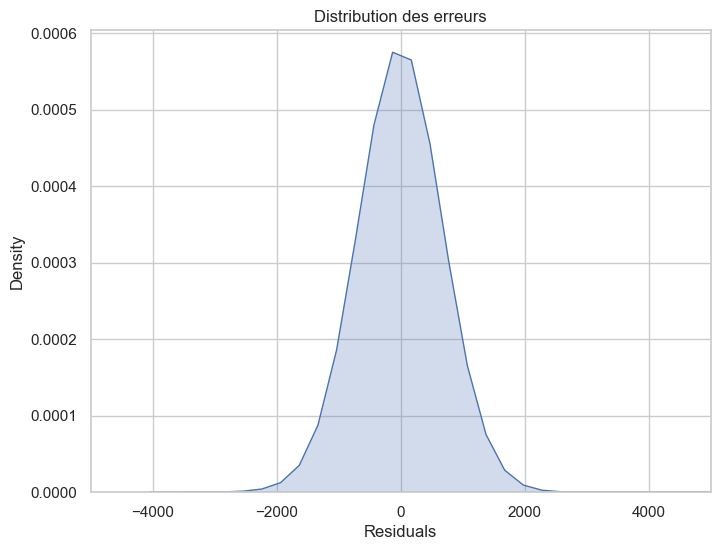

In [88]:
residuals = mod1b.resid
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, bw_adjust=7, shade=True)  # Adjust bandwidth as needed
plt.title('Distribution des erreurs')
plt.xlim(-5000, 5000)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

#### Modèle 1c - Modèle log-niveau

In [90]:
# Model 1c
model1c_formula = 'log_prixM2_FE ~ lag3_ir_FE+prop_maison_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod1c = run_regression(immo_reg_com_diff, model1c_formula)

test_breuschpagan = het_breuschpagan(mod1c.resid,  mod1c.model.exog)
test_breuschpagan

(55.05691313744796,
 0.16927064199097414,
 1.312407437400525,
 0.08497273045097632)

In [95]:
mod1c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_prixM2_FE   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     381.7
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:24:43   Log-Likelihood:                 13045.
No. Observations:               10395   AIC:                        -2.600e+04
Df Residuals:                   10352   BIC:                        -2.569e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0048      0.001      7.210      0.000       0.003       0.006
C(Date)[T.20140401]     3.435e-13   3.16e-14     10.880      0.000    2.82e-13    4.05e-13
C(Date)[T.20140701]    -9.151e-12   1.05e-12     -8.727      0.000   -1.12e-11    -7.1e-12
C(Date)[T.20141001]        0.0856      0.004     22.666      0.000       0.078       0.093
C(Date)[T.20150101]        0.0602      0.004     15.904      0.000       0.053       0.068
C(Date)[T.20150401]        0.0318      0.004      8.298      0.000       0.024       0.039
C(Date)[T.20150701]        0.0251      0.004      6.423      0.000       0.017       0.033
C(Date)[T.20151001]        0.0040      0.004      1.022      0.307      -0.004       0.012
C(Date)[T.20160101]       -0.0429      0.004    -10.920      0.000      -0.051      -0.035
C(Date)[T.20160401]       -0.0492      0.004    -12.504      0.000      -0.057      -0.041
C(Date)[T.20160701]       -0.0138      0.004     -3.496      0.000      -0.022      -0.006
C(Date)[T.20161001]       -0.0097      0.004     -2.471      0.013      -0.017      -0.002
C(Date)[T.20170101]       -0.0494      0.004    -12.521      0.000      -0.057      -0.042
C(Date)[T.20170401]       -0.0618      0.004    -15.630      0.000      -0.070      -0.054
C(Date)[T.20170701]       -0.0704      0.004    -17.683      0.000      -0.078      -0.063
C(Date)[T.20171001]       -0.0753      0.004    -19.021      0.000      -0.083      -0.068
C(Date)[T.20180101]       -0.0700      0.004    -17.697      0.000      -0.078      -0.062
C(Date)[T.20180401]       -0.0644      0.004    -16.278      0.000      -0.072      -0.057
C(Date)[T.20180701]       -0.0417      0.004    -10.503      0.000      -0.050      -0.034
C(Date)[T.20181001]       -0.0466      0.004    -11.765      0.000      -0.054      -0.039
C(Date)[T.20190101]       -0.0508      0.004    -12.848      0.000      -0.059      -0.043
C(Date)[T.20190401]       -0.0454      0.004    -11.469      0.000      -0.053      -0.038
C(Date)[T.20190701]       -0.0267      0.004     -6.762      0.000      -0.034      -0.019
C(Date)[T.20191001]       -0.0170      0.004     -4.315      0.000      -0.025      -0.009
C(Date)[T.20200101]       -0.0167      0.004     -4.220      0.000      -0.024      -0.009
C(Date)[T.20200401]       -0.0206      0.004     -5.228      0.000      -0.028      -0.013
C(Date)[T.20200701]       -0.0148      0.004     -3.759      0.000      -0.023      -0.007
C(Date)[T.20201001]        0.0037      0.004      0.934      0.350      -0.004       0.011
C(Date)[T.20210101]        0.0248      0.004      6.302      0.000       0.017       0.033
C(Date)[T.20210401]        0.0396      0.004     10.046      0.000       0.032       0.047
C(Date)[T.20210701]        0.0710      0.004     17.974      0.000       0.063  

Une critique possible de notre modèle est l'existance d'effets d'échelles relativement fort sur les prix, les prix immobilier pouvant varier fortement d'une ville à une autre. Ce modèle utilise donc une spécification log-niveau.
$$ \ddot{log(p_{nt})}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_M\ddot{M_{nt}} + \beta^{FE}_{ic}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{D}D+\varepsilon_t$$

### 4. Modèle avec prix dé-tendanciés

Les prix immobiliers n'étant pas un processus stationaire il existe un risque de corrélations falacieuse, en enlevant la tendance de l'évolution des prix le processus ne devient pas stationaire mais ceci réduit le risque d'obtenir des résultats liée à la hausse des prix sur la période, pour simplifier les calculs ce modèle n'inclus pas d'effets fixes. Il s'agit une estimation en deux étapes. 
1) Régression des prix sur le temps avec t le nombre de trimestres depuis le début du panel pour chaque groupe : $$ p_{nt}=\beta_0+\beta_{tn}t$$ 

2) Régression des prix réduit de la tendance linéaire estimé sur le taux d'interet et les interactions : $$(p_{nt}-\beta_{nt}\times t)= \beta_0+\beta_iL^3(i_t)+\beta_MM_{nt} + \beta_c X_{nc}+\beta_{ic}L^3(i_t)X_{nc}+\beta_{iM}L^3(i_t)M_{nt}+\beta_{D}D+\varepsilon_t $$

Ce modèle souffre  d'hétoskédacticité comme le montre le test Breuschpagan les coefficients sont donc affichés sous forme robuste

In [97]:
#DETRENDED REGRESSION
immo_reg_com_diff['time'] = immo_reg_com_diff.groupby('COM').cumcount() + 1
df_reg = immo_reg_com_diff.groupby('COM').apply(lambda x: smf.ols('prixM2 ~ time', data=x).fit().resid + x['prixM2']).reset_index(name='detrended_variable')
reg_immo2 = immo_reg_com_diff.groupby('COM').apply(lambda x: smf.ols('prixM2 ~ time', data=x).fit().params['time']).reset_index(name='estimate')
vroom = immo_reg_com_diff.reset_index(drop=False).merge(reg_immo2, on='COM')
vroom['prixM2_dt'] = vroom['prixM2'] - vroom['time'] * vroom['estimate']

model_detrend= 'prixM2_dt ~ lag_ir * (popdensity2020 + med_change + Physicist_access + Q219 + prop_maison + assault_for_1000 + dens_change) + prop_maison + C(AN)'
mod2 = run_regression(vroom, model_detrend)

test_breuschpagan = het_breuschpagan(mod2.resid,  mod2.model.exog)
test_breuschpagan

(136.3527108419013,
 1.084466825913895e-17,
 6.163436011267621,
 1.4516397046290936e-18)

In [98]:
mod2.get_robustcov_results(cov_type='HC2').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_dt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     2231.
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:25:09   Log-Likelihood:                -23851.
No. Observations:                2970   AIC:                         4.775e+04
Df Residuals:                    2946   BIC:                         4.789e+04
Df Model:                          23                                         
Covariance Type:                  HC2                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -4044.1629    636.609     -6.353      0.000   -5292.407   -2795.919
C(AN)[T.2015]             -97.3672    179.134     -0.544      0.587    -448.608     253.873
C(AN)[T.2016]            -312.2931    134.547     -2.321      0.020    -576.109     -48.477
C(AN)[T.2017]            -556.0836     77.173     -7.206      0.000    -707.401    -404.766
C(AN)[T.2018]            -513.4166     78.694     -6.524      0.000    -667.717    -359.116
C(AN)[T.2019]            -570.7153     77.569     -7.358      0.000    -722.811    -418.620
C(AN)[T.2020]            -595.2595     90.602     -6.570      0.000    -772.908    -417.611
C(AN)[T.2021]            -454.3949     88.082     -5.159      0.000    -627.103    -281.687
C(AN)[T.2022]            -478.4914     99.393     -4.814      0.000    -673.379    -283.604
C(AN)[T.2023]            -466.1414    112.707     -4.136      0.000    -687.134    -245.149
lag_ir                    504.4140    385.277      1.309      0.191    -251.025    1259.853
popdensity2020              0.1743      0.014     12.512      0.000       0.147       0.202
med_change                 -0.0656      0.135     -0.485      0.628      -0.331       0.200
Physicist_access          -43.3179     49.884     -0.868      0.385    -141.129      54.493
Q219                        0.2682      0.018     14.538      0.000       0.232       0.304
prop_maison              -405.4612    319.505     -1.269      0.205   -1031.937     221.015
assault_for_1000          237.8641     38.207      6.226      0.000     162.949     312.779
dens_change                -0.0814      0.251     -0.324      0.746      -0.574       0.411
lag_ir:popdensity2020      -0.0295      0.008     -3.928      0.000      -0.044      -0.015
lag_ir:med_change           0.0137      0.073      0.188      0.851      -0.129       0.157
lag_ir:Physicist_access     2.8101     26.608      0.106      0.916     -49.361      54.981
lag_ir:Q219                -0.0186      0.010     -1.876      0.061      -0.038       0.001
lag_ir:prop_maison       -251.9546    165.465     -1.523      0.128    -576.393      72.484
lag_ir:assault_for_1000   -32.3242     20.427     -1.582      0.114     -72.378       7.729
lag_ir:dens_change          0.0151      0.136      0.111      0.911      -0.251       0.281
==============================================================================
Omnibus:                     1187.127   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14255.740
Skew:                           1.554   Prob(JB):                         0.00
Kurtosis:                      13.273   Cond. No.                     5.78e+18
==============================================================================

Notes:
[1] Standard Errors are h

Ce modèle à la particularité d'avoir peu de coefficients statistiquement signifactifs mais les effets croisés taux d'interets densité reste significatifs à un niveau inférieur à 1% et l'interactions avec les revenus est significative à un niveau d'environ 6%. Il semblerait donc que l'essentiels de nos conclusions soit robuste à un retranchement de tendance. 

### 5. Modèles ZE (Zone d'Emploi)

#### Modèle 3 - Spécification ZE du modèle complet

En estimant notre modèle zone d'emploi (ie. $n$ représente une zone d'emploi) et y ajoutant le taux de chomage au même retard que le taux d'interet (pour simplifier l'interprétation) : $$\ddot{p_{nt}}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_V\ddot{Z_{nt}} + \beta^{FE}_{IC}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{IV}[\ddot{L^3(i_t)Z_{nt}}]+\beta^{FE}_{D}D+\varepsilon_t$$
 $Z_{nt}$ inclus toutes les charactéristiques variante dans le temps par zone d'emploi (ie. chomage et proportion de maisons vendues dans le total). Ce modèle souffre également d'hétoskédacticité comme le montre le test Breuschpagan les coefficients sont donc affichés sous forme robuste

In [99]:
# Part 4: Linear Regression Models
# Model mod3
mod3_formula = 'prixM2_FE ~ lag3_ir_FE+prop_maison_FE+lag3_UNEMP_FE+lag3_UNEMP_ir_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod3 = run_regression(immo_reg_ze_diff, mod3_formula)

test_breuschpagan = het_breuschpagan(mod3.resid,  mod3.model.exog)
test_breuschpagan

(571.8528922595933,
 8.736833495319525e-91,
 13.92534096683,
 5.436322622017272e-97)

In [100]:
mod3.get_robustcov_results(cov_type='HC2').summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 45
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_FE   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     237.1
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:25:23   Log-Likelihood:                -47778.
No. Observations:                7945   AIC:                         9.565e+04
Df Residuals:                    7900   BIC:                         9.596e+04
Df Model:                          44                                         
Covariance Type:                  HC2                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.2522      1.091      4.813      0.000       3.113       7.391
C(Date)[T.20140401]    -5.597e-11    6.5e-12     -8.606      0.000   -6.87e-11   -4.32e-11
C(Date)[T.20140701]    -5.915e-09   1.45e-09     -4.083      0.000   -8.76e-09   -3.08e-09
C(Date)[T.20141001]       85.2659     10.025      8.506      0.000      65.615     104.917
C(Date)[T.20150101]       56.8203      9.427      6.027      0.000      38.340      75.301
C(Date)[T.20150401]       30.3807      8.583      3.540      0.000      13.556      47.206
C(Date)[T.20150701]       41.7524      7.822      5.338      0.000      26.418      57.086
C(Date)[T.20151001]       18.9876      6.669      2.847      0.004       5.915      32.060
C(Date)[T.20160101]      -38.9480      7.080     -5.501      0.000     -52.827     -25.069
C(Date)[T.20160401]      -40.2154      6.635     -6.061      0.000     -53.222     -27.208
C(Date)[T.20160701]        3.9877      5.920      0.674      0.501      -7.616      15.592
C(Date)[T.20161001]       -6.5526      6.047     -1.084      0.279     -18.407       5.302
C(Date)[T.20170101]      -47.8516      6.017     -7.953      0.000     -59.646     -36.057
C(Date)[T.20170401]      -62.3006      6.558     -9.500      0.000     -75.157     -49.445
C(Date)[T.20170701]      -53.4389      8.228     -6.495      0.000     -69.567     -37.310
C(Date)[T.20171001]      -76.0019      6.365    -11.940      0.000     -88.480     -63.524
C(Date)[T.20180101]      -93.8185      6.227    -15.066      0.000    -106.025     -81.612
C(Date)[T.20180401]      -88.5560      6.505    -13.614      0.000    -101.307     -75.805
C(Date)[T.20180701]      -55.9744      6.460     -8.665      0.000     -68.637     -43.311
C(Date)[T.20181001]      -59.6792      7.272     -8.207      0.000     -73.934     -45.425
C(Date)[T.20190101]      -94.8510      4.541    -20.888      0.000    -103.752     -85.950
C(Date)[T.20190401]      -93.2928      3.949    -23.626      0.000    -101.033     -85.552
C(Date)[T.20190701]      -59.2968      4.118    -14.398      0.000     -67.370     -51.224
C(Date)[T.20191001]      -52.9533      3.661    -14.464      0.000     -60.130     -45.776
C(Date)[T.20200101]      -86.3143      4.469    -19.315      0.000     -95.074     -77.554
C(Date)[T.20200401]      -90.4526      4.793    -18.873      0.000     -99.848     -81.057
C(Date)[T.20200701]      -74.2625      5.035    -14.748      0.000     -84.133     -64.392
C(Date)[T.20201001]      -48.5679      5.431     -8.943      0.000     -59.213     -37.922
C(Date)[T.20210101]      -33.1216      7.724     -4.288      0.000     -48.263     -17.980
C(Date)[T.20210401]       46.0371      6.831      6.740      0.000      32.647      59.428
C(Date)[T.20210701]       89.5919      7.541     11.880      0.000      74.809  

Les résultats sont cohérents avec nos résultats précédents mais on remarque que le coefficients associés au chomage capture la majorité de l'effet précédement attribué aux revenus. Il semblerait que les revenus médians soit un proxy général de la santé économique locale.

### 6. Modèles EPCI (Établissement Public de Coopération Intercommunale)

#### Modèle 4 - Spécification EPCI du modèle complet

Pour finir, nous estimons notre modèle au niveau EPCI : $$\ddot{p_{nt}}= \beta^{FE}_0+\beta^{FE}_i\ddot{L^3(i_t)}+\beta^{FE}_M\ddot{M_{nt}} + \beta^{FE}_{ic}[\ddot{L^3(i_t)X_{nc}}]+\beta^{FE}_{D}D+\varepsilon_t$$ Ce modèle souffre également d'hétoskédacticité comme le montre le test Breuschpagan les coefficients sont donc affichés sous forme robuste.

In [101]:
# Model mod5
mod5_formula = 'prixM2_FE ~ lag3_ir_FE+prop_maison_FE + (popdensity2020_ir_FE + med_change_ir_FE + Physicist_access_ir_FE + Q219_ir_FE + assault_for_1000_ir_FE + dens_change_ir_FE + prop_maison_ir_FE) + C(Date)'
mod5 = run_regression(immo_reg_epci_diff, mod5_formula)

test_breuschpagan = het_breuschpagan(mod5.resid,  mod5.model.exog)
test_breuschpagan

(321.1675378195044,
 6.273719229190743e-43,
 8.01757098939098,
 2.1410200338125056e-46)

In [102]:
mod5.get_robustcov_results(cov_type='HC2').summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 43
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              prixM2_FE   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     259.2
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:25:42   Log-Likelihood:                -28190.
No. Observations:                4095   AIC:                         5.647e+04
Df Residuals:                    4051   BIC:                         5.675e+04
Df Model:                          43                                         
Covariance Type:                  HC2                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 31.1942      3.655      8.534      0.000      24.028      38.361
C(Date)[T.20140401]    -8.335e-08   7.49e-08     -1.113      0.266    -2.3e-07    6.35e-08
C(Date)[T.20140701]     1.147e-06   1.03e-06      1.116      0.264   -8.68e-07    3.16e-06
C(Date)[T.20141001]    -1383.5739   1630.784     -0.848      0.396   -4580.807    1813.660
C(Date)[T.20150101]    -1360.5868   1519.116     -0.896      0.370   -4338.889    1617.715
C(Date)[T.20150401]    -1257.3107   1295.736     -0.970      0.332   -3797.666    1283.045
C(Date)[T.20150701]    -1070.6322   1072.617     -0.998      0.318   -3173.550    1032.286
C(Date)[T.20151001]     -949.7068    875.510     -1.085      0.278   -2666.188     766.775
C(Date)[T.20160101]     -825.3456    596.541     -1.384      0.167   -1994.894     344.203
C(Date)[T.20160401]     -778.1023    518.851     -1.500      0.134   -1795.335     239.130
C(Date)[T.20160701]     -765.1316    667.205     -1.147      0.252   -2073.220     542.957
C(Date)[T.20161001]     -743.2291    600.401     -1.238      0.216   -1920.344     433.886
C(Date)[T.20170101]     -493.9704    284.481     -1.736      0.083   -1051.710      63.769
C(Date)[T.20170401]     -268.1838     20.772    -12.911      0.000    -308.908    -227.460
C(Date)[T.20170701]      -72.8088    188.950     -0.385      0.700    -443.254     297.636
C(Date)[T.20171001]      -77.9883    218.938     -0.356      0.722    -507.227     351.250
C(Date)[T.20180101]      -70.8837    148.159     -0.478      0.632    -361.356     219.589
C(Date)[T.20180401]      -81.2559     89.038     -0.913      0.362    -255.819      93.307
C(Date)[T.20180701]        6.4781     96.545      0.067      0.947    -182.804     195.760
C(Date)[T.20181001]       42.6169    133.988      0.318      0.750    -220.073     305.307
C(Date)[T.20190101]       52.3677    172.714      0.303      0.762    -286.246     390.982
C(Date)[T.20190401]      167.1851    213.187      0.784      0.433    -250.778     585.148
C(Date)[T.20190701]      280.5281    246.624      1.137      0.255    -202.991     764.047
C(Date)[T.20191001]      297.3378    241.132      1.233      0.218    -175.413     770.089
C(Date)[T.20200101]      412.0370    312.260      1.320      0.187    -200.164    1024.238
C(Date)[T.20200401]      550.8939    460.437      1.196      0.232    -351.815    1453.603
C(Date)[T.20200701]      710.1836    582.811      1.219      0.223    -432.446    1852.813
C(Date)[T.20201001]      765.3904    597.817      1.280      0.201    -406.660    1937.441
C(Date)[T.20210101]      695.2131    501.344      1.387      0.166    -287.697    1678.123
C(Date)[T.20210401]      706.3836    471.554      1.498      0.134    -218.122    1630.889
C(Date)[T.20210701]      830.6393    509.090      1.632      0.103    -167.457  

Ces résultats sont similaires même si l'effet total du taux d'interet est réduit à cause du coefficient associé à $E[B^{FE}_i|(\ddot{L^3(i_t)X_{nc}})=0]$  qui est positif et est égal à 1882 même si il n'est pas significatif à 5%. L'effet de l'évolution des revenus est par ailleurs plus fort que dans les autres modèles.